In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os

import xarray
from scipy.signal import sweep_poly

from hdpgpc.get_data import compute_estimators_LDS
import math
from scipy.fft import fft
import h5py
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import wavespectra as wv
import xarray as xr
import importlib
import pickle
import hdpgpc.GPI_HDP as hdpgp
import re
from datetime import datetime, timedelta
import time

/home/adrian.perez/Documents/OceanWave/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from hdpgpc.util_plots import print_results
import hdpgpc.util_plots as up
importlib.reload(up)
from hdpgpc.buoy_utils import interpolate_spectral_coefficients

/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/hdpgpc/buoy_utils.py:1918: UserWarning:

Numba not available. Install with: pip install numba



---

### 1. Lectura de datos

In [3]:
cwd = os.path.dirname(os.getcwd())
data_path = os.path.join(cwd, 'data', 'ocean', 'wawaves')
f_hillary = h5py.File(os.path.join(data_path, 'Hillarys_202407.mat'),'r')
f_hillary_2 = h5py.File(os.path.join(data_path, 'Hillarys_202408.mat'),'r')
#f = h5py.File(os.path.join(data_path, 'TIDE_SouthAfricaDrifting03_202406.mat'),'r')
print(f_hillary.get('SpotData').keys())
direction = np.concatenate([np.array(f_hillary.get('SpotData/direction')), np.array(f_hillary_2.get('SpotData/direction'))], axis=1)
variance_density = np.concatenate([np.array(f_hillary.get('SpotData/varianceDensity')), np.array(f_hillary_2.get('SpotData/varianceDensity'))], axis=1)
spec_time_hillarys = np.concatenate([np.array(f_hillary.get('SpotData/spec_time')), np.array(f_hillary_2.get('SpotData/spec_time'))], axis=1)
time_hillarys = np.concatenate([np.array(f_hillary.get('SpotData/time')), np.array(f_hillary_2.get('SpotData/time'))], axis=1)
frequency_hillarys = np.concatenate([np.array(f_hillary.get('SpotData/frequency')), np.array(f_hillary_2.get('SpotData/frequency'))], axis=1)
dm_h = np.concatenate([np.array(f_hillary.get('SpotData/dm')), np.array(f_hillary_2.get('SpotData/dm'))], axis=1)
a1 = np.concatenate([np.array(f_hillary.get('SpotData/a1')), np.array(f_hillary_2.get('SpotData/a1'))], axis=1)
a2 = np.concatenate([np.array(f_hillary.get('SpotData/a2')), np.array(f_hillary_2.get('SpotData/a2'))], axis=1)
b1 = np.concatenate([np.array(f_hillary.get('SpotData/b1')), np.array(f_hillary_2.get('SpotData/b1'))], axis=1)
b2 = np.concatenate([np.array(f_hillary.get('SpotData/b2')), np.array(f_hillary_2.get('SpotData/b2'))], axis=1)

print(variance_density.shape)
print(direction.shape)
print(a1.shape)
print(np.array(f_hillary.get('SpotData/dmspr')).shape)



<KeysViewHDF5 ['a1', 'a2', 'b1', 'b2', 'bott_temp', 'df', 'direction', 'directionalSpread', 'dm', 'dm_sea', 'dm_swell', 'dmspr', 'dmspr_sea', 'dmspr_swell', 'dp', 'dpspr', 'endFreq_sea', 'endFreq_swell', 'frequency', 'hsig', 'hsig_sea', 'hsig_swell', 'lat', 'lon', 'name', 'part_time', 'press_std_time', 'press_time', 'pressure', 'pressure_std', 'qf_bott_temp', 'qf_sst', 'qf_waves', 'serialID', 'spec_time', 'startFreq_sea', 'startFreq_swell', 'surf_temp', 'temp_time', 'time', 'tm', 'tm_sea', 'tm_swell', 'tp', 'varianceDensity', 'wind_dir', 'wind_seasurfaceId', 'wind_speed', 'wind_time']>
(79, 2936)
(79, 2936)
(79, 2936)
(1, 744)


In [4]:
# result = interpolate_spectral_coefficients(
#     frequency_hillarys[:,0],
#     variance_density,
#     a1, b1, a2, b2,
#     n_points=200,
#     enforce_constraints=True
# )
# frequency_hillarys_dense = np.array([result['f_dense']]*frequency_hillarys.shape[1]).T
# S_dense = result['variance_density_dense']
# plt.plot(frequency_hillarys[:,0],variance_density[:,0])
# plt.plot(frequency_hillarys_dense[:,0], S_dense[:,0])
#
# frequency_hillarys = frequency_hillarys_dense
# variance_density = S_dense
# a1, b1, a2, b2 = result['a1_dense'], result['b1_dense'], result['a2_dense'], result['b2_dense']

In [5]:
startFreq_sea = np.array(f_hillary.get('SpotData/startFreq_sea'))[0][0]
startFreq_swell = np.array(f_hillary.get('SpotData/startFreq_swell'))[0][0]
print(frequency_hillarys.shape)

(79, 2936)


In [6]:
print("Shape of the data: ")
print(variance_density.shape)
num_obs_per_sample, num_samples  = variance_density.shape

Shape of the data: 
(79, 2936)


In [7]:
S_theta =  np.zeros((variance_density.shape[1], variance_density.shape[0], 37))
directions = np.deg2rad(np.linspace(0, 360.0, 37))
delta_theta = np.deg2rad(10.0)
for t in range(S_theta.shape[0]):
    for f in range(S_theta.shape[1]):
        # Load S(f), a1, b1, a2, b2 for this time and frequency
        S = variance_density[f, t]# Omnidirectional spectrum
        a1_, b1_, a2_, b2_ = a1[f,t], b1[f,t], a2[f,t], b2[f,t]  # Directional moments

        for i, theta in enumerate(directions):
            # Compute D(f, theta)
            D = (1 / 2 * np.pi) * (
                    1 + (a1_ * np.cos(theta) + b1_ * np.sin(theta))
                    + (a2_ * np.cos(2 * theta) + b2_ * np.sin(2 * theta))
            )

            # Ensure non-negativity
            D = max(D, 0)

            # Compute S(f, theta)
            S_theta[t, f, i] = S * D

        # Optional: Renormalize to ensure sum(S_theta * delta_theta) ≈ S
        integral = np.sum(S_theta[t, f, :]) * delta_theta
        integral = integral if integral > 0 else 1.0
        S_theta[t, f, :] *= S / integral  # Adjust if integral != S

Time event
2024-08-02 00:00:00
1519


/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/hdpgpc/buoy_utils.py:1887: UserWarning:

The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.



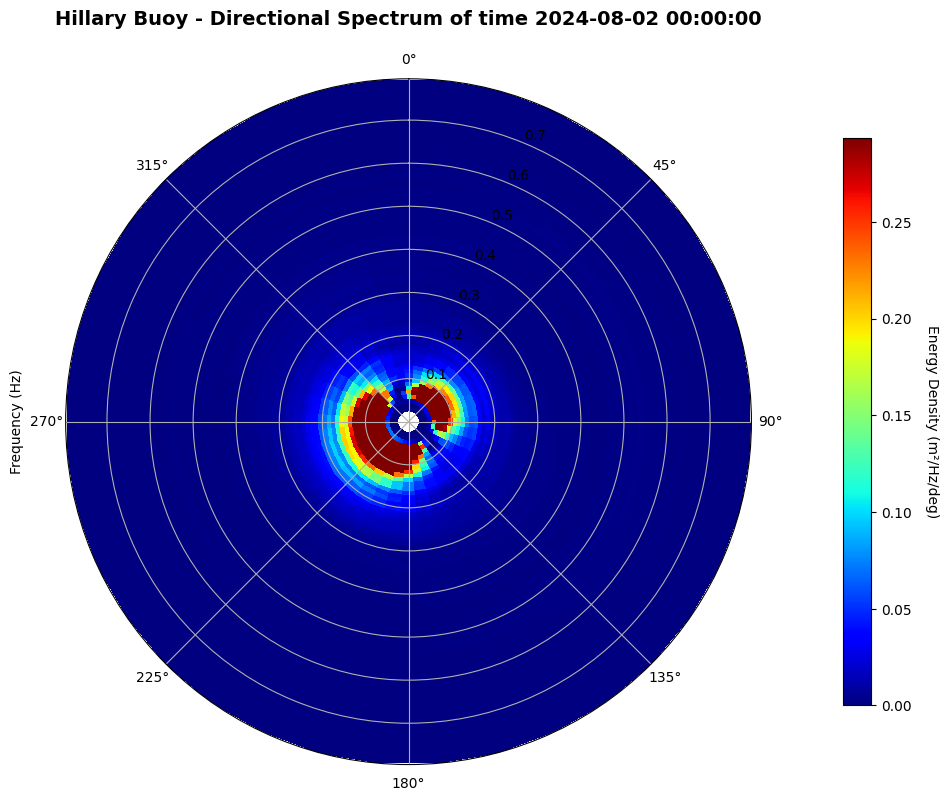

In [8]:
from hdpgpc import buoy_utils
from datetime import datetime, timedelta
#Trying to transform data and direction to 3 dim data.
# direction_segments = np.floor(direction / 5.0).astype(np.int32)
# data_np = np.zeros((variance_density.shape[1], variance_density.shape[0], 73))
# for i, d in enumerate(data_np):
#     for t, dir in enumerate(direction_segments[:, i]):
#         d[t,dir] = d[t,dir] + variance_density[t, i]

dirs = np.linspace(0, 360.0, 37)
import hdpgpc.buoy_utils as buoy_utils
ind_ = 0

error_spectra, error_fourier = buoy_utils.compute_rotation_deviation(S_theta[ind_], dirs, a1[:,ind_], b1[:,ind_], dm_h[:,ind_])
dirs = (dirs + error_spectra - 55) % 360.0

dataset = xr.Dataset(
    data_vars=dict(
        efth=(["time", "freq", "dir"], S_theta)
    ),
    coords=dict(
        time=(["time"], spec_time_hillarys[0]),
        freq=(["freq"], frequency_hillarys[:,0]),
        dir=(["dir"], dirs)
    )
)
dts_hillarys = wv.SpecDataset(dataset)
new_dirs = np.linspace(0, 360, 37)# Cada 10° incluyendo 360°
directions_hillarys = new_dirs
data_ = dts_hillarys.interp(dir=new_dirs)
freq = data_.freq
freq_hillarys = data_.freq

time_select_datetime = datetime(2024, 8, 2, 0)
time_select_ordinal = datetime.toordinal(time_select_datetime + timedelta(days = 366))
index_hillary = np.argmin(np.abs(spec_time_hillarys - time_select_ordinal))
print("Time event")
print(time_select_datetime)
print(index_hillary)
fig, ax = buoy_utils.plot_directional_spectrum(freq, directions_hillarys, data_[index_hillary],
                                        title='Hillary Buoy - Directional Spectrum of time '+ str(time_select_datetime))


In [9]:
# data_shoal = np.load("/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/data/ocean/wawaves/Hillarys_0708_shoaled.npy")
# print(data_shoal.shape)
# data = data_shoal
data = data_.to_numpy()
freq_ = np.array(freq)

Shape of hs: (2936, 1)
How much spectra falls in the range 0.5-1.5 Hs: 2936


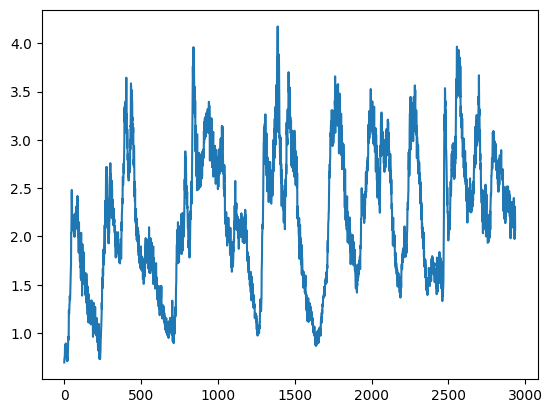

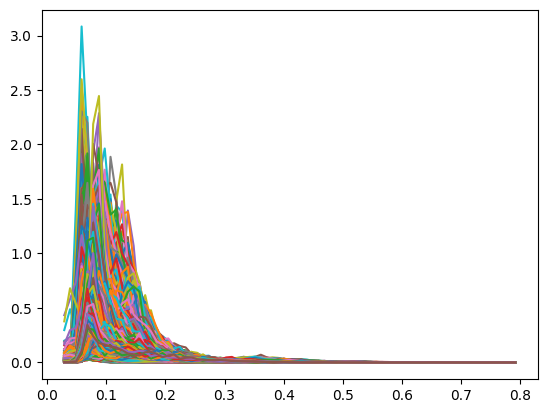

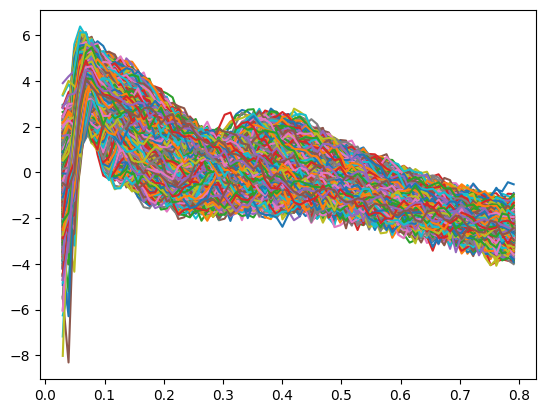

In [10]:
 #Here we are going to compute the Heighs and try to filter following Hamiltons rule.
interv = np.repeat(freq_[1]-freq_[0], num_obs_per_sample)[:, np.newaxis]
hs_h = 4 * np.sqrt(np.sum(data, axis=2) * delta_theta @ interv)
print("Shape of hs: "+str(hs_h.shape))
plt.plot(hs_h)
chosen_indexes = np.where((hs_h > 0.5) & (hs_h < 1.5))[0]
chosen_indexes = np.arange(num_samples)
print("How much spectra falls in the range 0.5-1.5 Hs: " + str(chosen_indexes.shape[0]))
plt.show()
plt.plot(freq, data[:,:,0][chosen_indexes].T)
plt.show()
lognorm_data = np.log(data + 1e-6) - np.mean(np.log(data+ 1e-6), axis=1)[:,np.newaxis,:]
plt.plot(freq, lognorm_data[:,:,0][chosen_indexes].T)
plt.show()


### Se cogen solo los datos de un año natural

In [11]:
#Select indexes
data = data[chosen_indexes]
print("Shape of the data: ")
print(data.shape)

num_samples, num_obs_per_sample, num_outputs = data.shape

Shape of the data: 
(2936, 79, 37)


In [12]:
lim_freq = startFreq_sea
index_freq = np.where(freq>lim_freq)[0][0]+1
std, std_dif, bound_sigma, bound_gamma = compute_estimators_LDS(data[:,0:index_freq,:], n_f=50, dim=25)
#Seem like these estimators are so big for this data, let's reduce them
std = std * 0.5
std_dif = std_dif * 0.48
bound_sigma = (std * 1e-7, std * 1e-6)
bound_gamma = (std_dif * 1e-9, std_dif * 1e-8)

print("Final sigma:", std)
print("Final gamma:", std_dif)
print("Final sigma bound:", bound_sigma)
print("Final gamma bound:", bound_gamma)

M = 2
sigma = [std * 1.0] * M
gamma = [std_dif * 1.0] * M
outputscale_ = 0.1
ini_lengthscale = 1e-3
bound_lengthscale = (1e-7, 5e-3)
samples = [0, num_obs_per_sample]
l, L = samples[0], samples[1]
# x_basis has to have the same dimension structure as data[0], in this case (171,1) but it could be (n_inducing_points, 1).
lim_freq = startFreq_sea
index_freq = np.where(freq>lim_freq)[0][0]+1
x_basis = np.atleast_2d(freq[0:index_freq]).T
x_train = np.atleast_2d(freq[0:index_freq]).T
print(x_train.shape)
#If x_basis is wanted to be smaller than the observations length, then the inducing points approach can be applied setting this parameter to True.
inducing_points = False
#Choose if warp is going to be applied. (In the most recent version is optimized to work with online inference, but it can be used in offline as an additional step at the end of the clustering).
warp = False
#Warp priors
noise_warp = std * 0.1
bound_noise_warp = (noise_warp * 0.1, noise_warp * 0.2)
#Warp time indexes
x_basis_warp = np.atleast_2d(np.arange(freq[0], freq[-1], freq.shape[0] / 2.0, dtype=np.float64)).T

Sigma estimated: 0.02649246919956853
Gamma estimated: 0.02649246919956853
Final sigma: 0.013246234599784265
Final gamma: 0.012716385215792894
Final sigma bound: (1.3246234599784263e-09, 1.3246234599784265e-08)
Final gamma bound: (np.float64(1.2716385215792896e-11), np.float64(1.2716385215792895e-10))
(12, 1)


In [ ]:
sw_gp_hillary = hdpgp.GPI_HDP(x_basis=x_basis, x_basis_warp=x_basis_warp, n_outputs=37,
                          ini_lengthscale=ini_lengthscale, bound_lengthscale=bound_lengthscale,
                          ini_gamma=gamma, ini_sigma=sigma, ini_outputscale=outputscale_, noise_warp=noise_warp,
                          bound_sigma=bound_sigma, bound_gamma=bound_gamma, bound_noise_warp=bound_noise_warp,
                          verbose=False, max_models=100, inducing_points=inducing_points, reestimate_initial_params=False,
                          n_explore_steps=15, free_deg_MNIV=8, share_gp=True, use_snr=False, reduce_outputs=True, reduce_outputs_ratio=0.05)

cluster_labels_h = np.load('/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/cluster_labels/resampled_low_freq/cluster_labels_hillary_202407_dynamic_4.npy')
# ------ Cluster grouping on dynamic_3 ------
# cluster_labels_h[np.where(cluster_labels_h == 1)] = 0
# #cluster_labels_h[np.where(cluster_labels_h == 5)] = 0
# cluster_labels_h[np.where(cluster_labels_h == 2)] = 1
# cluster_labels_h[np.where(cluster_labels_h == 3)] = 2
# cluster_labels_h[np.where(cluster_labels_h == 4)] = 3
# cluster_labels_h[np.where(cluster_labels_h == 6)] = 4
#
# #After-transformations
# cluster_labels_h[np.where(cluster_labels_h == 4)] = 3
# cluster_labels_h[np.where(cluster_labels_h == 5)] = 4

# ------ Cluster grouping on dynamic ------
# cluster_labels_h[np.where(cluster_labels_h == 3)] = 0
# cluster_labels_h[np.where(cluster_labels_h == 5)] = 0
# cluster_labels_h[np.where(cluster_labels_h == 6)] = 0
# cluster_labels_h[np.where(cluster_labels_h == 7)] = 0
#
# cluster_labels_h[np.where(cluster_labels_h == 4)] = 3
# cluster_labels_h[np.where(cluster_labels_h == 8)] = 4
# cluster_labels_h[np.where(cluster_labels_h == 9)] = 5
#
# #After transform
# cluster_labels_h[np.where(cluster_labels_h == 3)] = 2
# cluster_labels_h[np.where(cluster_labels_h == 4)] = 2
# cluster_labels_h[np.where(cluster_labels_h == 5)] = 2

# ------ Cluster grouping on dynamic 4 ------

# cluster_labels_h[np.where(cluster_labels_h == 2)] = 1
M = np.unique(cluster_labels_h).shape[0]
num_samples = data.shape[0]
#logdata = np.log(data + 1e-6)
x_trains = np.array([x_train] * num_samples)
sw_gp_hillary.reload_model_from_labels(x_trains, data[:,0:index_freq,:], cluster_labels_h, M)

In [14]:
sw_gp_hillary.gpmodels[0][0].x_train[0].shape

torch.Size([12, 1])

Model 1 : MainModel: N : [N-1976]
Model 2 : MainModel: N : [N-630]
Model 3 : MainModel: N : [N-240]
Model 4 : MainModel: N : [N-90]
Classification error: 0 / 2936 -- 0.00000


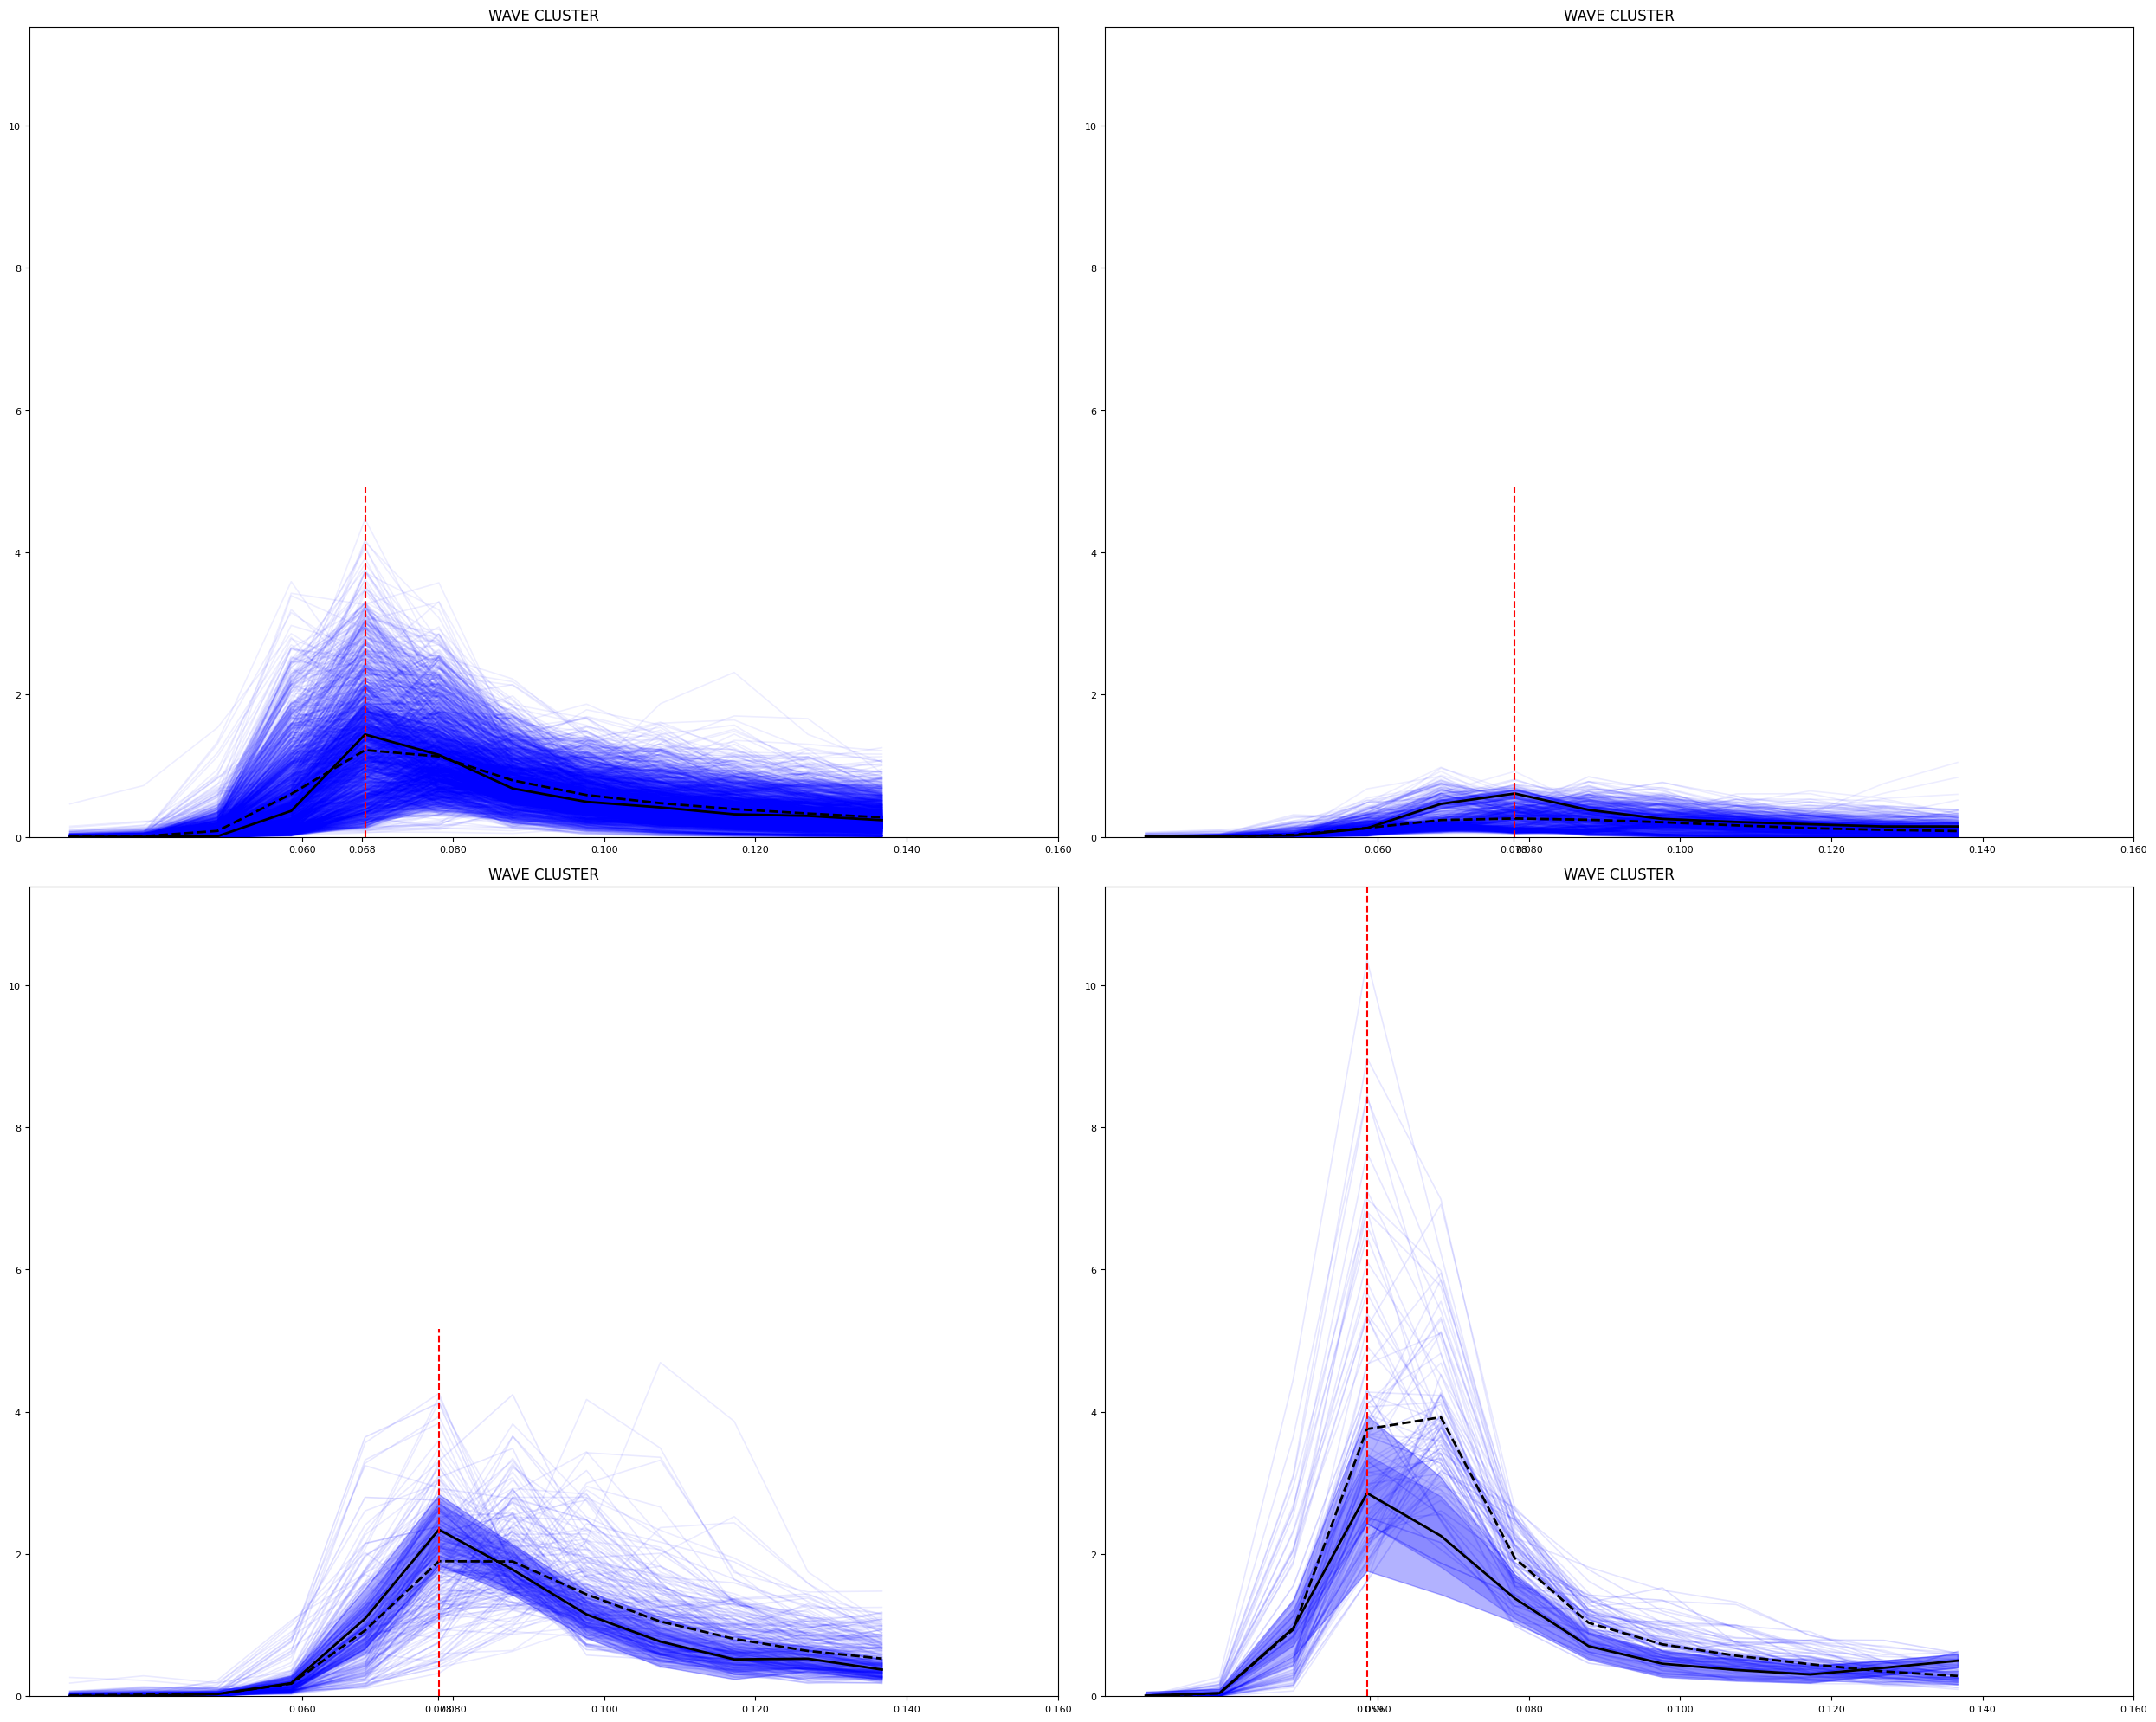

In [15]:
labels = np.array(['N'] * 6500)
main_model = print_results(sw_gp_hillary, labels, 0, error=False)
selected_gpmodels = sw_gp_hillary.selected_gpmodels()
up.plot_models_plotly(sw_gp_hillary, selected_gpmodels, main_model, labels, N_0=0, lead=26, step=(freq[1]-freq[0])/1,
                   plot_latent=False, title='WAVE CLUSTER',ticks=True, yscale=True, save="/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/clusters_hillary.png", line_max=True)

Now with drifting 03.

In [16]:

cwd = os.path.dirname(os.getcwd())
data_path = os.path.join(cwd, 'data', 'ocean', 'wawaves')
#f = h5py.File(os.path.join(data_path, 'Hillarys_202405.mat'), 'r')
f_drift03 = h5py.File(os.path.join(data_path, 'TIDE_SouthAfricaDrifting03_202407.mat'),'r')
f_drift03_2 = h5py.File(os.path.join(data_path, 'TIDE_SouthAfricaDrifting03_202408.mat'),'r')
print(f_drift03.get('SpotData').keys())
direction = np.concatenate([np.array(f_drift03.get('SpotData/direction')), np.array(f_drift03_2.get('SpotData/direction'))], axis=1)
variance_density = np.concatenate([np.array(f_drift03.get('SpotData/varianceDensity')), np.array(f_drift03_2.get('SpotData/varianceDensity'))], axis=1)
spec_time_drift03 = np.concatenate([np.array(f_drift03.get('SpotData/spec_time')), np.array(f_drift03_2.get('SpotData/spec_time'))], axis=1)
time_drift03 = np.concatenate([np.array(f_drift03.get('SpotData/time')), np.array(f_drift03_2.get('SpotData/time'))], axis=1)
frequency = np.concatenate([np.array(f_drift03.get('SpotData/frequency')), np.array(f_drift03_2.get('SpotData/frequency'))], axis=1)
dm_d03 = np.concatenate([np.array(f_drift03.get('SpotData/dm')), np.array(f_drift03_2.get('SpotData/dm'))], axis=1)
a1 = np.concatenate([np.array(f_drift03.get('SpotData/a1')), np.array(f_drift03_2.get('SpotData/a1'))], axis=1)
a2 = np.concatenate([np.array(f_drift03.get('SpotData/a2')), np.array(f_drift03_2.get('SpotData/a2'))], axis=1)
b1 = np.concatenate([np.array(f_drift03.get('SpotData/b1')), np.array(f_drift03_2.get('SpotData/b1'))], axis=1)
b2 = np.concatenate([np.array(f_drift03.get('SpotData/b2')), np.array(f_drift03_2.get('SpotData/b2'))], axis=1)
print("Shape of the data: ")
print(variance_density.shape)

# result = interpolate_spectral_coefficients(
#     frequency[:,0],
#     variance_density,
#     a1, b1, a2, b2,
#     n_points=200,
#     enforce_constraints=True
# )
# frequency_drift03_dense = np.array([result['f_dense']]*frequency.shape[1]).T
# S_dense = result['variance_density_dense']
# plt.plot(frequency[:,0],variance_density[:,0])
# plt.plot(frequency_drift03_dense[:,0], S_dense[:,0])
#
# frequency = frequency_drift03_dense
# variance_density = S_dense
# a1, b1, a2, b2 = result['a1_dense'], result['b1_dense'], result['a2_dense'], result['b2_dense']


<KeysViewHDF5 ['a1', 'a2', 'b1', 'b2', 'bott_temp', 'df', 'direction', 'directionalSpread', 'dm', 'dm_sea', 'dm_swell', 'dmspr', 'dmspr_sea', 'dmspr_swell', 'dp', 'dpspr', 'endFreq_sea', 'endFreq_swell', 'frequency', 'hsig', 'hsig_sea', 'hsig_swell', 'lat', 'lon', 'name', 'part_time', 'press_std_time', 'press_time', 'pressure', 'pressure_std', 'qf_bott_temp', 'qf_sst', 'qf_waves', 'serialID', 'spec_time', 'startFreq_sea', 'startFreq_swell', 'surf_temp', 'temp_time', 'time', 'tm', 'tm_sea', 'tm_swell', 'tp', 'varianceDensity', 'wind_dir', 'wind_seasurfaceId', 'wind_speed', 'wind_time']>
Shape of the data: 
(39, 645)


In [17]:
num_obs_per_sample, num_samples = variance_density.shape
S_theta = np.zeros((variance_density.shape[1], variance_density.shape[0], 37))
directions = np.deg2rad(np.linspace(0, 360.0, 37))
delta_theta = np.deg2rad(10.0)

In [18]:
for t in range(S_theta.shape[0]):
    for f in range(S_theta.shape[1]):
        # Load S(f), a1, b1, a2, b2 for this time and frequency
        S = variance_density[f, t]  # Omnidirectional spectrum
        a1_, b1_, a2_, b2_ = a1[f, t], b1[f, t], a2[f, t], b2[f, t]  # Directional moments
        if a1_ == -9999.0:
            a1_, b1_, a2_, b2_ = 0.0, 0.0, 0.0, 0.0
        for i, theta in enumerate(directions):
            # Compute D(f, theta)
            D = (1 / 2 * np.pi) * (
                    1 + (a1_ * np.cos(theta) + b1_ * np.sin(theta))
                    + (a2_ * np.cos(2 * theta) + b2_ * np.sin(2 * theta))
            )

            # Ensure non-negativity
            D = max(D, 0)

            # Compute S(f, theta)
            S_theta[t, f, i] = S * D

        # Optional: Renormalize to ensure sum(S_theta * delta_theta) ≈ S
        integral = np.sum(S_theta[t, f, :]) * delta_theta
        integral = integral if integral > 0 else 1.0
        S_theta[t, f, :] *= S / integral  # Adjust if integral != S


In [19]:
import hdpgpc.buoy_utils as buoy_utils
#Trying to transform data and direction to 3 dim data.
# direction_segments = np.floor(direction / 5.0).astype(np.int32)
# data_np = np.zeros((variance_density.shape[1], variance_density.shape[0], 73))
# for i, d in enumerate(data_np):
#     for t, dir in enumerate(direction_segments[:, i]):
#         d[t,dir] = d[t,dir] + variance_density[t, i]
dirs = np.linspace(0, 360.0, 37)
error_spectra, error_fourier = buoy_utils.compute_rotation_deviation(S_theta[0], dirs, a1[:,0], b1[:,0], dm_d03[:,0])
dirs = (dirs + error_spectra) % 360.0
dataset = xr.Dataset(
    data_vars=dict(
        efth=(["time", "freq", "dir"], S_theta)
    ),
    coords=dict(
        time=(["time"], spec_time_drift03[0]),
        freq=(["freq"], frequency[:, 0]),
        dir=(["dir"], dirs)
    )
)
dts_drift03 = wv.SpecDataset(dataset)
new_dirs = np.linspace(0, 360, 37)  # Cada 10° incluyendo 360°
data_drifting03 = dts_drift03.interp(dir=new_dirs)
freq = data_drifting03.freq
data_drifting03 = data_drifting03.to_numpy()
freq_ = np.array(freq)

(645, 39, 37)
(39, 1)
Shape of hs: (645, 1)
How much spectra falls in the range 0.5-1.5 Hs: 645


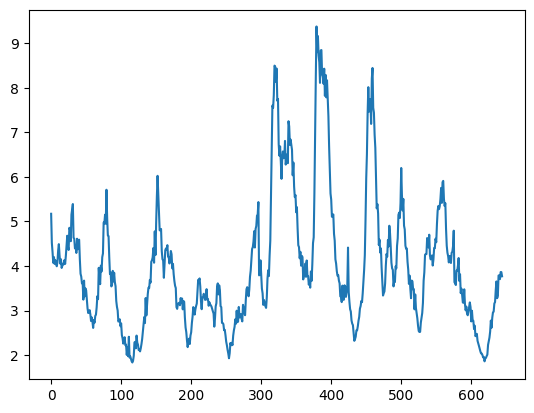

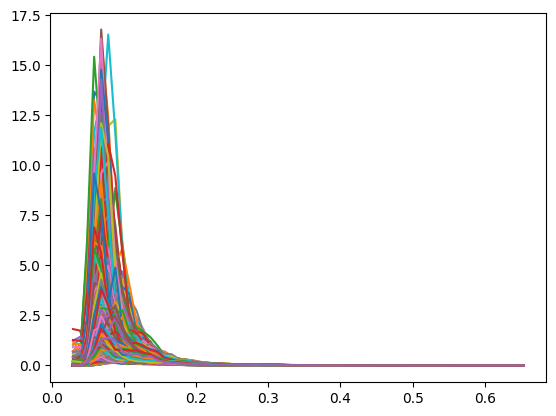

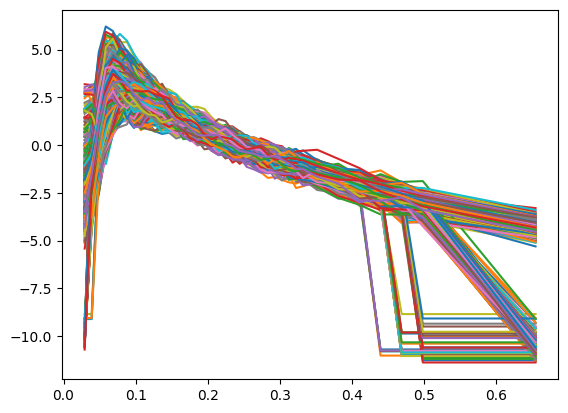

In [20]:
#Here we are going to compute the Heighs and try to filter following Hamiltons rule.
interv = np.repeat(freq_[1] - freq_[0], num_obs_per_sample)[:, np.newaxis]
print(data_drifting03.shape)
print(interv.shape)
hs_d03 = 4 * np.sqrt(np.sum(data_drifting03, axis=2) * delta_theta @ interv)
print("Shape of hs: " + str(hs_d03.shape))
plt.plot(hs_d03)
chosen_indexes = np.where((hs_d03 > 0.5) & (hs_d03 < 1.5))[0]
chosen_indexes = np.arange(num_samples)
print("How much spectra falls in the range 0.5-1.5 Hs: " + str(chosen_indexes.shape[0]))
plt.show()
plt.plot(freq, data_drifting03[:, :, 0][chosen_indexes].T)
plt.show()
lognorm_data = np.log(data_drifting03 + 1e-6) - np.mean(np.log(data_drifting03 + 1e-6), axis=1)[:, np.newaxis, :]
plt.plot(freq, lognorm_data[:, :, 0][chosen_indexes].T)
plt.show()

In [21]:
data_drifting03 = data_drifting03[chosen_indexes]
print("Shape of the data: ")
print(data_drifting03.shape)

lim_freq = startFreq_sea
index_freq = np.where(freq>lim_freq)[0][0]+1
num_samples, num_obs_per_sample, num_outputs = data_drifting03.shape
std, std_dif, bound_sigma, bound_gamma = compute_estimators_LDS(data_drifting03[:,0:index_freq,:], n_f=50, dim=25)
#Seem like these estimators are so big for this data, let's reduce them
std = std * 1.0
std_dif = std_dif * 0.1
bound_sigma = (std * 1e-7, std * 1e-6)
bound_gamma = (std_dif * 1e-9, std_dif * 1e-8)

print("Final sigma:", std)
print("Final gamma:", std_dif)
print("Final sigma bound:", bound_sigma)
print("Final gamma bound:", bound_gamma)

M = 2
sigma = [std * 1.0] * M
gamma = [std_dif * 1.0] * M
outputscale_ = 0.1
ini_lengthscale = 1e-3
bound_lengthscale = (1e-7, 5e-3)
samples = [0, num_obs_per_sample]
l, L = samples[0], samples[1]
# x_basis has to have the same dimension structure as data[0], in this case (171,1) but it could be (n_inducing_points, 1).
lim_freq = startFreq_sea
index_freq = np.where(freq>lim_freq)[0][0]+1
x_basis = np.atleast_2d(freq[0:index_freq]).T
x_train = np.atleast_2d(freq[0:index_freq]).T
print(x_train.shape)
#If x_basis is wanted to be smaller than the observations length, then the inducing points approach can be applied setting this parameter to True.
inducing_points = False
#Choose if warp is going to be applied. (In the most recent version is optimized to work with online inference, but it can be used in offline as an additional step at the end of the clustering).
warp = False
#Warp priors
noise_warp = std * 0.1
bound_noise_warp = (noise_warp * 0.1, noise_warp * 0.2)
#Warp time indexes
x_basis_warp = np.atleast_2d(np.arange(freq[0], freq[-1], freq.shape[0] / 2.0, dtype=np.float64)).T

Shape of the data: 
(645, 39, 37)
Sigma estimated: 0.03816953106488801
Gamma estimated: 0.03816953106488801
Final sigma: 0.03816953106488801
Final gamma: 0.0038169531064888014
Final sigma bound: (3.816953106488801e-09, 3.816953106488801e-08)
Final gamma bound: (np.float64(3.816953106488801e-12), np.float64(3.816953106488801e-11))
(12, 1)


In [22]:
sw_gp_drift03 = hdpgp.GPI_HDP(x_basis=x_basis, x_basis_warp=x_basis_warp, n_outputs=37,
                          ini_lengthscale=ini_lengthscale, bound_lengthscale=bound_lengthscale,
                          ini_gamma=gamma, ini_sigma=sigma, ini_outputscale=outputscale_, noise_warp=noise_warp,
                          bound_sigma=bound_sigma, bound_gamma=bound_gamma, bound_noise_warp=bound_noise_warp,
                          verbose=False, max_models=100, inducing_points=inducing_points, reestimate_initial_params=False,
                          n_explore_steps=15, free_deg_MNIV=8, share_gp=True, use_snr=False, reduce_outputs=True, reduce_outputs_ratio=0.2)

cluster_labels_d03 = np.load('/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/cluster_labels/resampled_low_freq/cluster_labels_drift03_202407_dynamic_4.npy')
# ------ Cluster grouping on dynamic 2 ------
# cluster_labels_d03[np.where(cluster_labels_d03 == 1)] = 0
# cluster_labels_d03[np.where(cluster_labels_d03 == 2)] = 0
# cluster_labels_d03[np.where(cluster_labels_d03 == 4)] = 0
#
# cluster_labels_d03[np.where(cluster_labels_d03 == 7)] = 5
# #cluster_labels_d03[np.where(cluster_labels_d03 == 8)] = 5
#
# cluster_labels_d03[np.where(cluster_labels_d03 == 3)] = 1
# cluster_labels_d03[np.where(cluster_labels_d03 == 5)] = 2
# cluster_labels_d03[np.where(cluster_labels_d03 == 6)] = 3
# cluster_labels_d03[np.where(cluster_labels_d03 == 8)] = 4
#
# #After-transformations
# cluster_labels_d03[np.where(cluster_labels_d03 == 2)] = 1
# cluster_labels_d03[np.where(cluster_labels_d03 == 3)] = 1
# cluster_labels_d03[np.where(cluster_labels_d03 == 4)] = 1
# cluster_labels_d03[np.where(cluster_labels_d03 == 5)] = 1

# ------ Cluster grouping on dynamic 4 ------

M = np.unique(cluster_labels_d03).shape[0]
num_samples = data_drifting03.shape[0]
#logdata = np.log(data + 1e-6)
x_trains = np.array([x_train] * num_samples)
sw_gp_drift03.reload_model_from_labels(x_trains, data_drifting03[:,0:index_freq,:], cluster_labels_d03, M)

---Kernel estimated---
1.82**2 * RBF(length_scale=0.0168) + WhiteKernel(noise_level=3.54e-08)
Group responsability estimated: [303 203 139]
Sum resp_temp: [303 203 139]
Q_em: -11656.41, Q_lat: -84833.93, Elbo_linear: -232.27, Elbo_LDS: -203.67

-------ELBO:tensor([-96926.2821])-------


Model 1 : MainModel: N : [N-303]
Model 2 : MainModel: N : [N-203]
Model 3 : MainModel: N : [N-139]
Classification error: 0 / 645 -- 0.00000


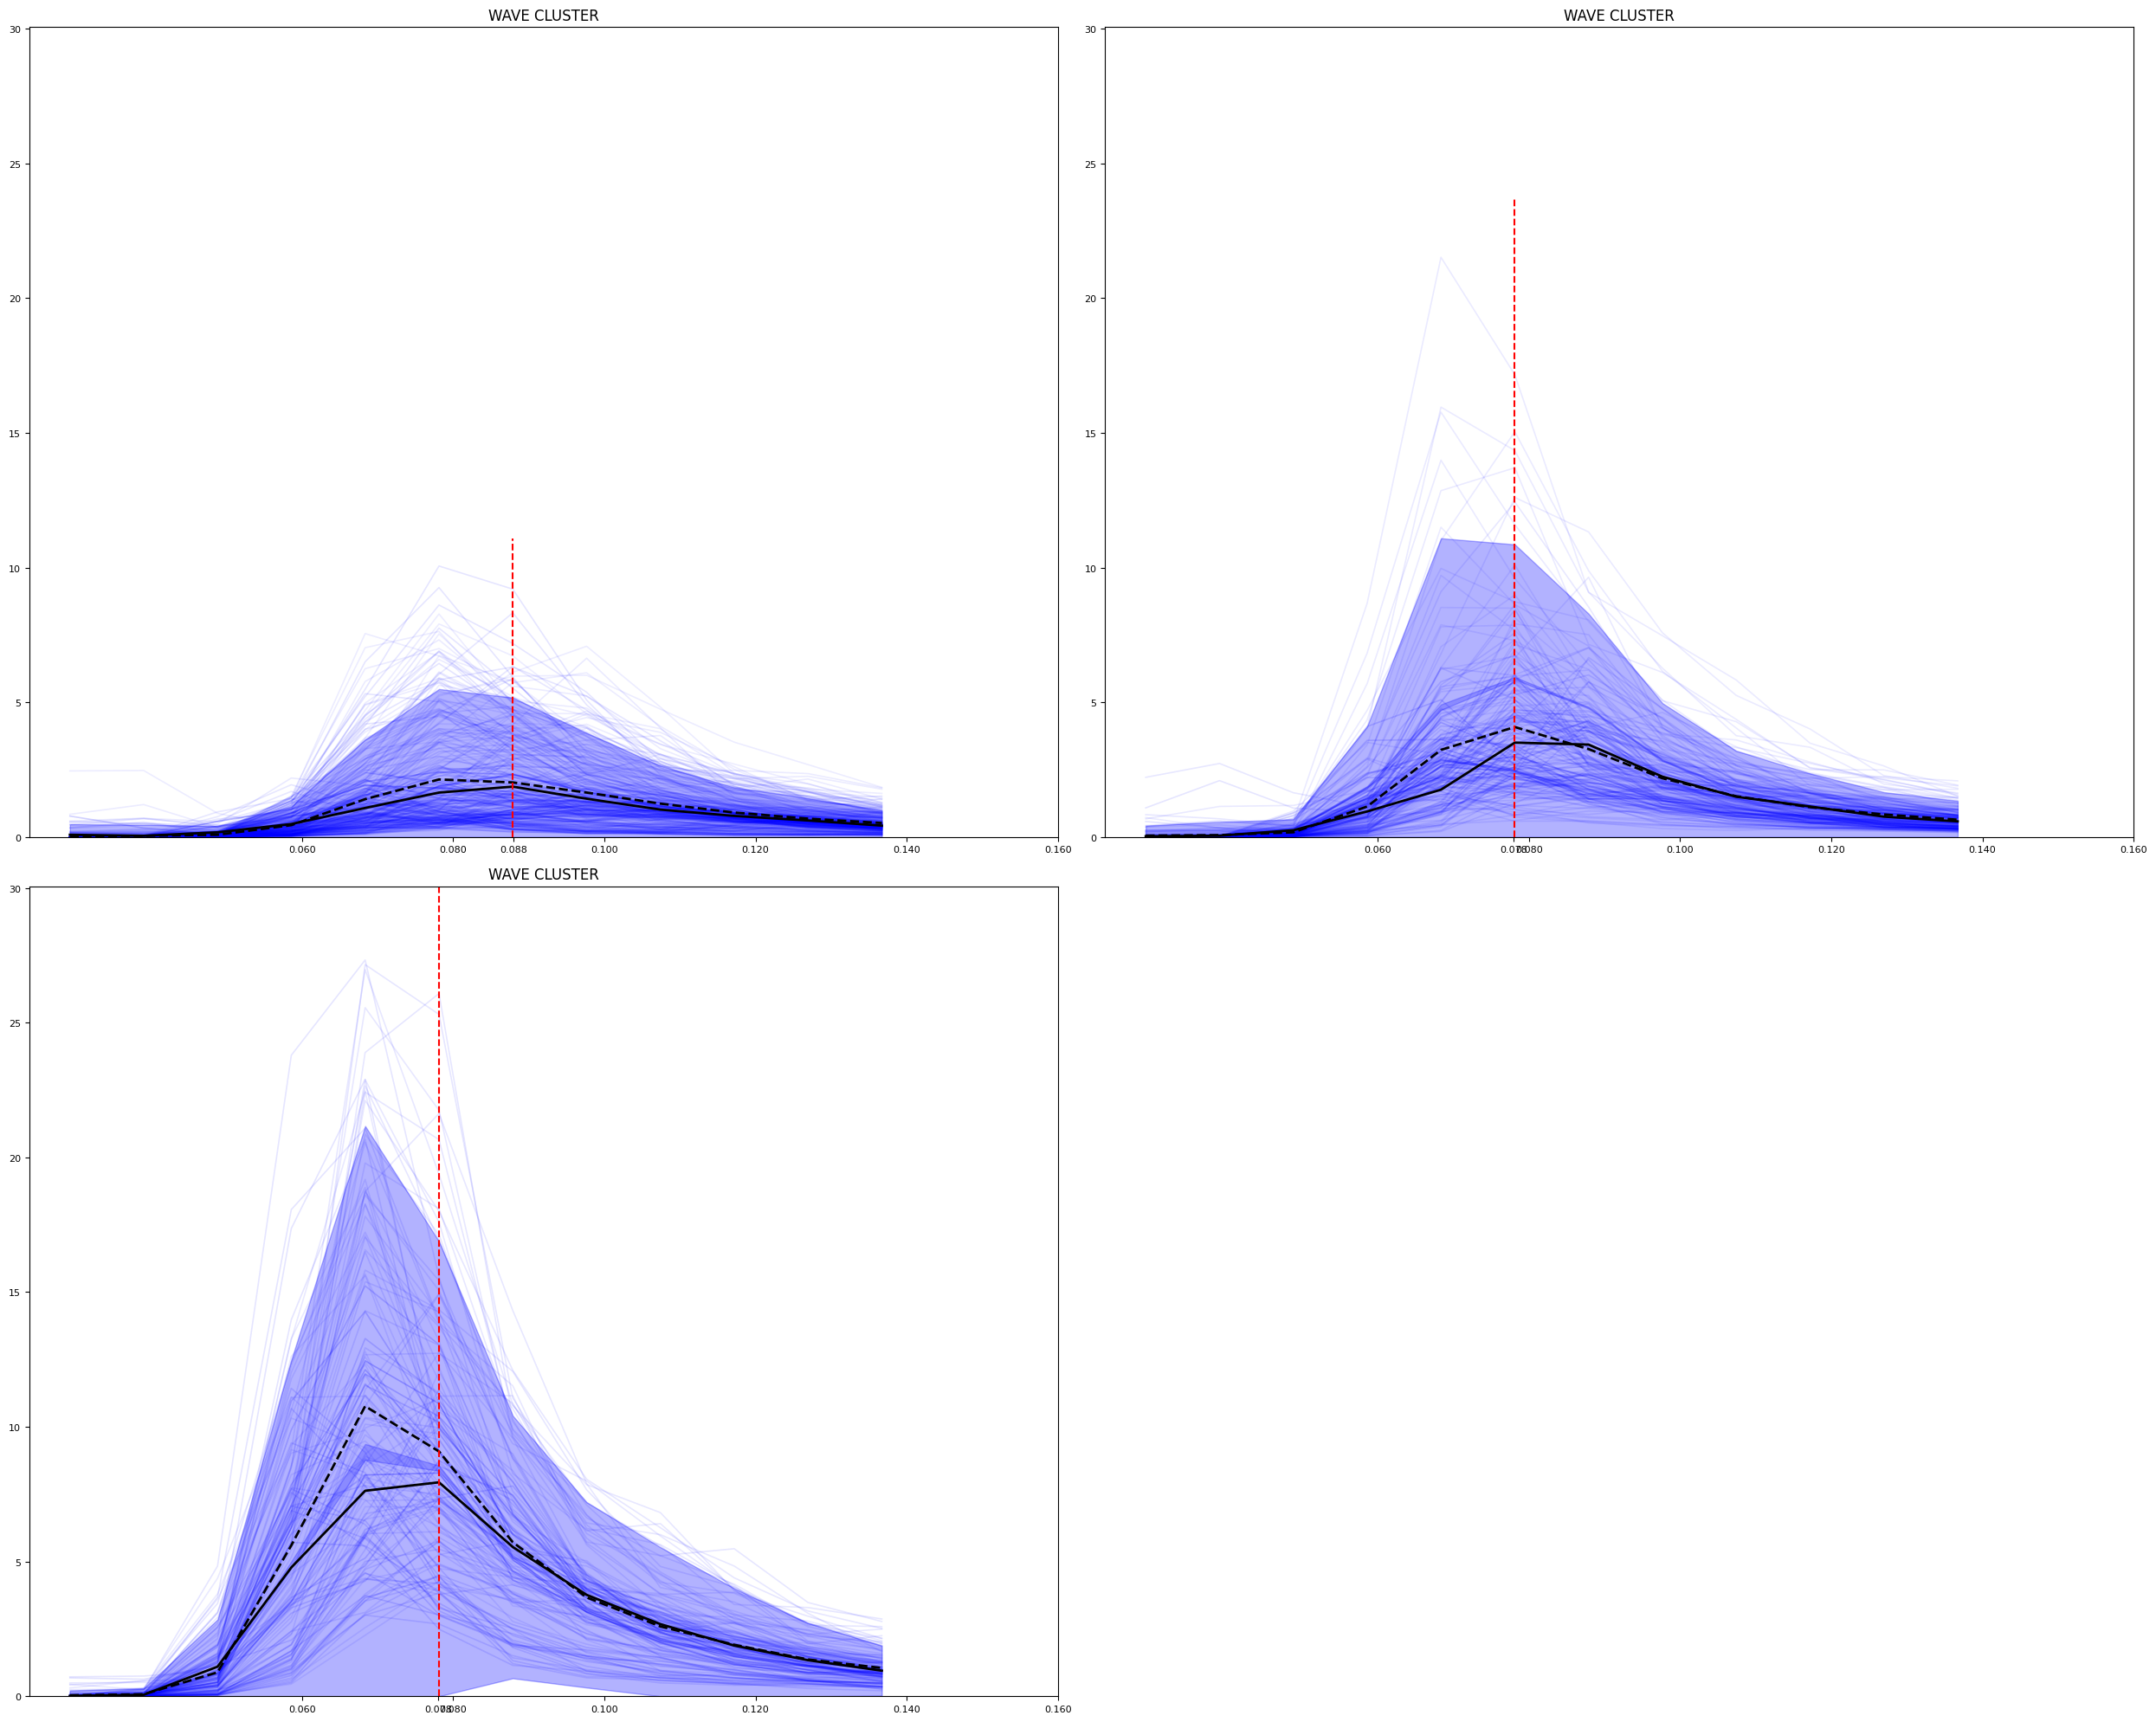

In [23]:
labels = np.array(['N'] * 6500)
main_model = print_results(sw_gp_drift03, labels, 0, error=False)
selected_gpmodels = sw_gp_drift03.selected_gpmodels()
up.plot_models_plotly(sw_gp_drift03, selected_gpmodels, main_model, labels, N_0=0, lead=26, step=(freq[1]-freq[0])/1,
                   plot_latent=False, title='WAVE CLUSTER',ticks=True, yscale=True, save="/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/clusters_drift03.png", line_max=True)

Now with drifting 06.

In [24]:

cwd = os.path.dirname(os.getcwd())
data_path = os.path.join(cwd, 'data', 'ocean', 'wawaves')
#f = h5py.File(os.path.join(data_path, 'Hillarys_202405.mat'), 'r')
f_drift06 = h5py.File(os.path.join(data_path, 'TIDE_SouthAfricaDrifting08_202407.mat'), 'r')
f_drift06_2 = h5py.File(os.path.join(data_path, 'TIDE_SouthAfricaDrifting08_202408.mat'), 'r')
print(f_drift06.get('SpotData').keys())
direction = np.concatenate([np.array(f_drift06.get('SpotData/direction')), np.array(f_drift06_2.get('SpotData/direction'))], axis=1)
variance_density = np.concatenate([np.array(f_drift06.get('SpotData/varianceDensity')), np.array(f_drift06_2.get('SpotData/varianceDensity'))], axis=1)
spec_time_drift06 = np.concatenate([np.array(f_drift06.get('SpotData/spec_time')), np.array(f_drift06_2.get('SpotData/spec_time'))], axis=1)
time_drift06 = np.concatenate([np.array(f_drift06.get('SpotData/time')), np.array(f_drift06_2.get('SpotData/time'))], axis=1)
frequency = np.concatenate([np.array(f_drift06.get('SpotData/frequency')), np.array(f_drift06_2.get('SpotData/frequency'))], axis=1)
dm_d06 = np.concatenate([np.array(f_drift06.get('SpotData/dm')), np.array(f_drift06_2.get('SpotData/dm'))], axis=1)
a1 = np.concatenate([np.array(f_drift06.get('SpotData/a1')), np.array(f_drift06_2.get('SpotData/a1'))], axis=1)
a2 = np.concatenate([np.array(f_drift06.get('SpotData/a2')), np.array(f_drift06_2.get('SpotData/a2'))], axis=1)
b1 = np.concatenate([np.array(f_drift06.get('SpotData/b1')), np.array(f_drift06_2.get('SpotData/b1'))], axis=1)
b2 = np.concatenate([np.array(f_drift06.get('SpotData/b2')), np.array(f_drift06_2.get('SpotData/b2'))], axis=1)
print("Shape of the data: ")
print(variance_density.shape)

# result = interpolate_spectral_coefficients(
#     frequency[:,0],
#     variance_density,
#     a1, b1, a2, b2,
#     n_points=200,
#     enforce_constraints=True
# )
# frequency_drift06_dense = np.array([result['f_dense']]*frequency.shape[1]).T
# S_dense = result['variance_density_dense']
# plt.plot(frequency[:,0],variance_density[:,0])
# plt.plot(frequency_drift06_dense[:,0], S_dense[:,0])

# frequency = frequency_drift06_dense
# variance_density = S_dense
# a1, b1, a2, b2 = result['a1_dense'], result['b1_dense'], result['a2_dense'], result['b2_dense']

<KeysViewHDF5 ['a1', 'a2', 'b1', 'b2', 'bott_temp', 'df', 'direction', 'directionalSpread', 'dm', 'dm_sea', 'dm_swell', 'dmspr', 'dmspr_sea', 'dmspr_swell', 'dp', 'dpspr', 'endFreq_sea', 'endFreq_swell', 'frequency', 'hsig', 'hsig_sea', 'hsig_swell', 'lat', 'lon', 'name', 'part_time', 'press_std_time', 'press_time', 'pressure', 'pressure_std', 'qf_bott_temp', 'qf_sst', 'qf_waves', 'serialID', 'spec_time', 'startFreq_sea', 'startFreq_swell', 'surf_temp', 'temp_time', 'time', 'tm', 'tm_sea', 'tm_swell', 'tp', 'varianceDensity', 'wind_dir', 'wind_seasurfaceId', 'wind_speed', 'wind_time']>
Shape of the data: 
(39, 747)


In [25]:

num_obs_per_sample, num_samples = variance_density.shape
S_theta = np.zeros((variance_density.shape[1], variance_density.shape[0], 37))
directions = np.deg2rad(np.linspace(0, 360.0, 37))
delta_theta = np.deg2rad(10.0)
for t in range(S_theta.shape[0]):
    for f in range(S_theta.shape[1]):
        # Load S(f), a1, b1, a2, b2 for this time and frequency
        S = variance_density[f, t]  # Omnidirectional spectrum
        a1_, b1_, a2_, b2_ = a1[f, t], b1[f, t], a2[f, t], b2[f, t]  # Directional moments

        for i, theta in enumerate(directions):
            # Compute D(f, theta)
            D = (1 / 2 * np.pi) * (
                    1 + (a1_ * np.cos(theta) + b1_ * np.sin(theta))
                    + (a2_ * np.cos(2 * theta) + b2_ * np.sin(2 * theta))
            )

            # Ensure non-negativity
            D = max(D, 0)

            # Compute S(f, theta)
            S_theta[t, f, i] = S * D

        # Optional: Renormalize to ensure sum(S_theta * delta_theta) ≈ S
        integral = np.sum(S_theta[t, f, :]) * delta_theta
        integral = integral if integral > 0 else 1.0
        S_theta[t, f, :] *= S / integral  # Adjust if integral != S

Shape of hs: (747, 1)
How much spectra falls in the range 0.5-1.5 Hs: 747


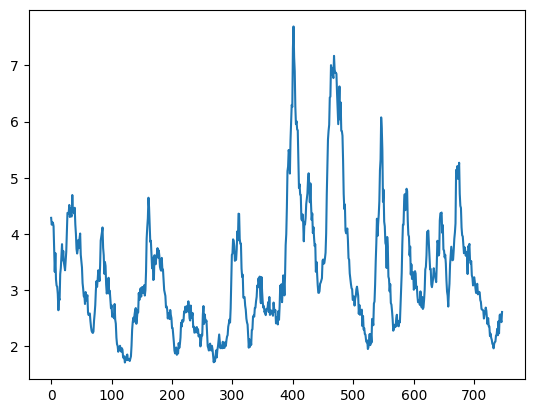

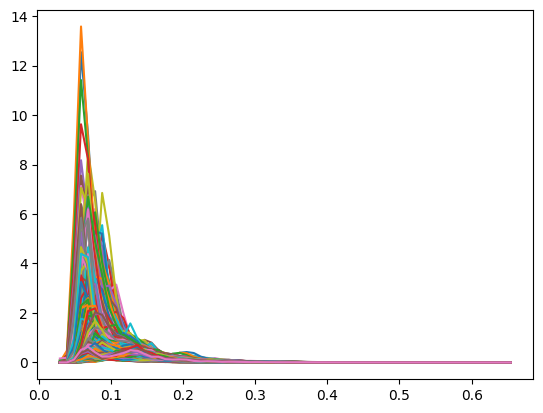

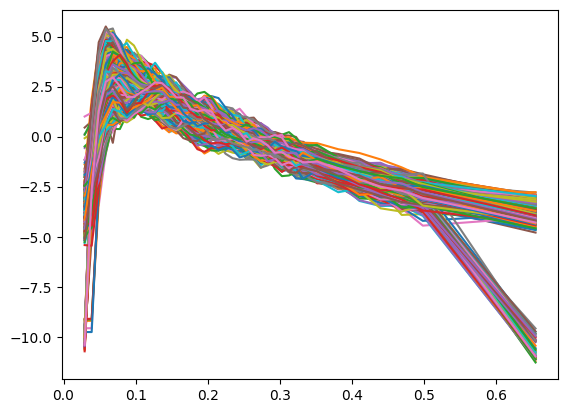

Shape of the data: 
(747, 39, 37)
Sigma estimated: 0.033932331240767624
Gamma estimated: 0.033932331240767624
Final sigma: 0.0008483082810191906
Final gamma: 0.000271458649926141
Final sigma bound: (8.483082810191906e-11, 8.483082810191906e-10)
Final gamma bound: (np.float64(2.7145864992614103e-13), np.float64(2.7145864992614098e-12))


In [26]:
import hdpgpc.buoy_utils as buoy_utils
#Trying to transform data and direction to 3 dim data.
# direction_segments = np.floor(direction / 5.0).astype(np.int32)
# data_np = np.zeros((variance_density.shape[1], variance_density.shape[0], 73))
# for i, d in enumerate(data_np):
#     for t, dir in enumerate(direction_segments[:, i]):
#         d[t,dir] = d[t,dir] + variance_density[t, i]
dirs = np.linspace(0, 360.0, 37)
error_spectra, error_fourier = buoy_utils.compute_rotation_deviation(S_theta[0], dirs, a1[:,0], b1[:,0], dm_d06[:,0])
dirs = (dirs + error_spectra) % 360.0
dataset = xr.Dataset(
    data_vars=dict(
        efth=(["time", "freq", "dir"], S_theta)
    ),
    coords=dict(
        time=(["time"], spec_time_drift06[0]),
        freq=(["freq"], frequency[:, 0]),
        dir=(["dir"], dirs)
    )
)
dts_drift06 = wv.SpecDataset(dataset)
new_dirs = np.linspace(0, 360, 37)  # Cada 10° incluyendo 360°
data_drifting06 = dts_drift06.interp(dir=new_dirs)
freq = data_drifting06.freq
data_drifting06 = data_drifting06.to_numpy()
freq_ = np.array(freq)
#Here we are going to compute the Heighs and try to filter following Hamiltons rule.
interv = np.repeat(freq_[1] - freq_[0], num_obs_per_sample)[:, np.newaxis]
hs_d06 = 4 * np.sqrt(np.sum(data_drifting06, axis=2) * delta_theta @ interv)
print("Shape of hs: " + str(hs_d06.shape))
plt.plot(hs_d06)
chosen_indexes = np.where((hs_d06 > 0.5) & (hs_d06 < 1.5))[0]
chosen_indexes = np.arange(num_samples)
print("How much spectra falls in the range 0.5-1.5 Hs: " + str(chosen_indexes.shape[0]))
plt.show()
plt.plot(freq, data_drifting06[:, :, 0][chosen_indexes].T)
plt.show()
lognorm_data = np.log(data_drifting06 + 1e-6) - np.mean(np.log(data_drifting06 + 1e-6), axis=1)[:, np.newaxis, :]
plt.plot(freq, lognorm_data[:, :, 0][chosen_indexes].T)
plt.show()
data_drifting06 = data_drifting06[chosen_indexes]
print("Shape of the data: ")
print(data_drifting06.shape)

lim_freq = startFreq_sea
index_freq = np.where(freq>lim_freq)[0][0]+1
num_samples, num_obs_per_sample, num_outputs = data_drifting06.shape
std, std_dif, bound_sigma, bound_gamma = compute_estimators_LDS(data_drifting06[:, 0:index_freq, :], n_f=50, dim=25)
#Seem like these estimators are so big for this data, let's reduce them
std = std * 0.025
std_dif = std_dif * 0.008
bound_sigma = (std * 1e-7, std * 1e-6)
bound_gamma = (std_dif * 1e-9, std_dif * 1e-8)

print("Final sigma:", std)
print("Final gamma:", std_dif)
print("Final sigma bound:", bound_sigma)
print("Final gamma bound:", bound_gamma)

(12, 1)
---Kernel estimated---
1.66**2 * RBF(length_scale=0.0189) + WhiteKernel(noise_level=7.74e-10)
Group responsability estimated: [350 220 177]
Sum resp_temp: [350 220 177]
Q_em: -16134.54, Q_lat: -88614.08, Elbo_linear: -321.94, Elbo_LDS: -107.96

-------ELBO:tensor([-105178.5222])-------
Model 1 : MainModel: N : [N-350]
Model 2 : MainModel: N : [N-220]
Model 3 : MainModel: N : [N-177]
Classification error: 0 / 747 -- 0.00000


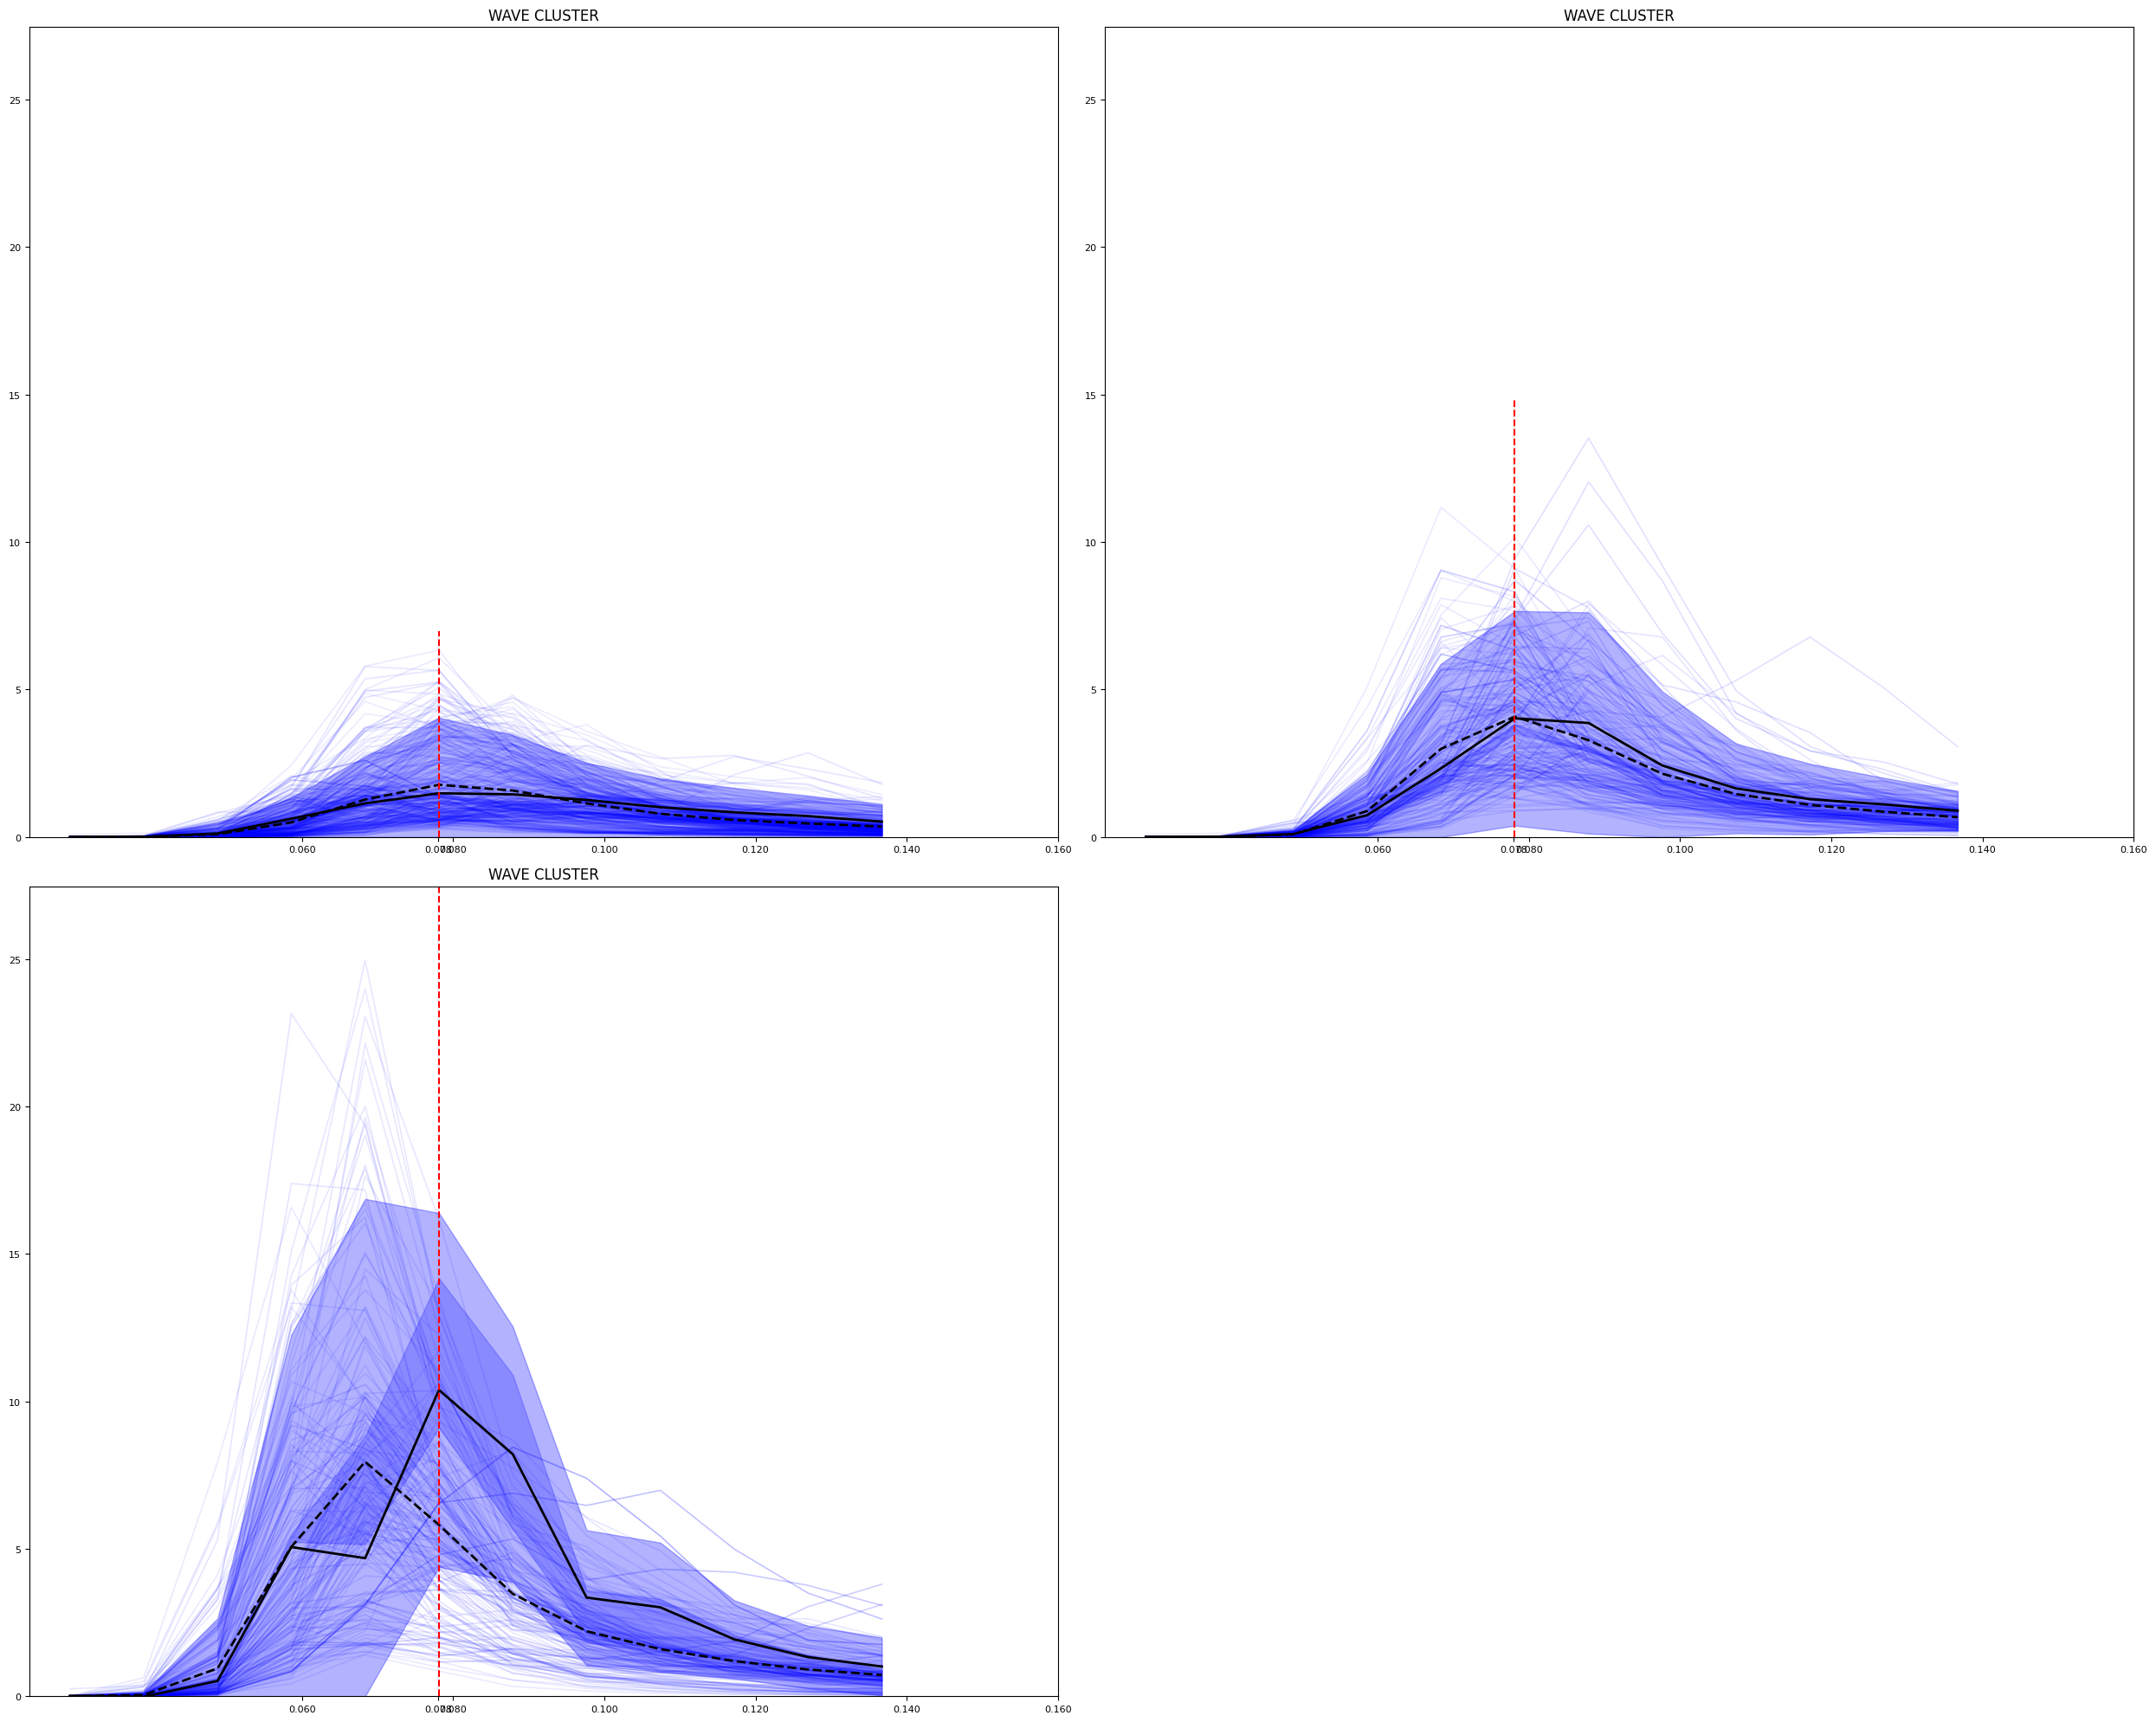

In [27]:

M = 2
sigma = [std * 1.0] * M
gamma = [std_dif * 1.0] * M
outputscale_ = 0.1
ini_lengthscale = 1e-3
bound_lengthscale = (1e-7, 5e-3)
samples = [0, num_obs_per_sample]
l, L = samples[0], samples[1]
# x_basis has to have the same dimension structure as data[0], in this case (171,1) but it could be (n_inducing_points, 1).
lim_freq = startFreq_sea
index_freq = np.where(freq>lim_freq)[0][0]+1
x_basis = np.atleast_2d(freq[0:index_freq]).T
x_train = np.atleast_2d(freq[0:index_freq]).T
print(x_train.shape)
#If x_basis is wanted to be smaller than the observations length, then the inducing points approach can be applied setting this parameter to True.
inducing_points = False
#Choose if warp is going to be applied. (In the most recent version is optimized to work with online inference, but it can be used in offline as an additional step at the end of the clustering).
warp = False
#Warp priors
noise_warp = std * 0.1
bound_noise_warp = (noise_warp * 0.1, noise_warp * 0.2)
#Warp time indexes
x_basis_warp = np.atleast_2d(np.arange(freq[0], freq[-1], freq.shape[0] / 2.0, dtype=np.float64)).T
sw_gp_drift06 = hdpgp.GPI_HDP(x_basis=x_basis, x_basis_warp=x_basis_warp, n_outputs=37,
                              ini_lengthscale=ini_lengthscale, bound_lengthscale=bound_lengthscale,
                              ini_gamma=gamma, ini_sigma=sigma, ini_outputscale=outputscale_, noise_warp=noise_warp,
                              bound_sigma=bound_sigma, bound_gamma=bound_gamma, bound_noise_warp=bound_noise_warp,
                              verbose=False, max_models=100, inducing_points=inducing_points,
                              reestimate_initial_params=False,
                              n_explore_steps=15, free_deg_MNIV=8, share_gp=True, use_snr=False, reduce_outputs=True,
                              reduce_outputs_ratio=0.2)

cluster_labels_d08 = np.load('/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/cluster_labels/resampled_low_freq/cluster_labels_drift08_202407_dynamic_4.npy')
# ------ Cluster grouping on dynamic 2 ------
# cluster_labels_d08[np.where(cluster_labels_d08 == 5)] = 3
# cluster_labels_d08[np.where(cluster_labels_d08 == 6)] = 3
#
# #After-transform
# cluster_labels_d08[np.where(cluster_labels_d08 == 4)] = 1
# cluster_labels_d08[np.where(cluster_labels_d08 == 3)] = 1
# cluster_labels_d08[np.where(cluster_labels_d08 == 2)] = 1

# ------ Cluster grouping on dynamic 4 ------
cluster_labels_d08[np.where(cluster_labels_d08 == 3)] = 2
cluster_labels_d08[np.where(cluster_labels_d08 == 4)] = 2
cluster_labels_d08[np.where(cluster_labels_d08 == 5)] = 2
cluster_labels_d08[np.where(cluster_labels_d08 == 6)] = 2

M = np.unique(cluster_labels_d08).shape[0]
num_samples = data_drifting06.shape[0]
#logdata = np.log(data + 1e-6)
x_trains = np.array([x_train] * num_samples)
sw_gp_drift06.reload_model_from_labels(x_trains, data_drifting06[:, 0:index_freq, :], cluster_labels_d08, M)
labels = np.array(['N'] * 6500)
main_model = print_results(sw_gp_drift06, labels, 0, error=False)
selected_gpmodels = sw_gp_drift06.selected_gpmodels()
up.plot_models_plotly(sw_gp_drift06, selected_gpmodels, main_model, labels, N_0=0, lead=26, step=(freq[1] - freq[0]) / 1,
                      plot_latent=False, title='WAVE CLUSTER', ticks=True, yscale=True,
                      save="/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/clusters_drift06.png", line_max=True)

In [28]:
print(spec_time_drift03.shape)
from datetime import datetime, timedelta

def matlab_datenum_to_datetime(matlab_datenum):
    """
    Convert MATLAB datenum to Python datetime.
    """
    days = int(matlab_datenum)
    frac = matlab_datenum % 1
    python_datetime = datetime.fromordinal(days - 366) + timedelta(days=frac)
    return python_datetime

data_time_drift03 = [matlab_datenum_to_datetime(t) for t in spec_time_drift03[0]]
data_time_drift06 = [matlab_datenum_to_datetime(t) for t in spec_time_drift06[0]]
data_time_hillarys = [matlab_datenum_to_datetime(t) for t in spec_time_hillarys[0]]
print(np.min(data_time_hillarys), np.max(data_time_hillarys))
print(np.min(data_time_drift03), np.max(data_time_drift03))
print(np.min(data_time_drift06), np.max(data_time_drift06))


(1, 645)
2024-07-01 00:00:00 2024-08-31 23:29:59.999997
2024-07-01 00:02:30.999996 2024-08-31 22:02:31.000002
2024-07-01 00:14:59.999997 2024-08-31 23:40:00.000001


# Gráfica distribución por meses y clusters

In [29]:

df_hillarys = pd.DataFrame({
    'time': data_time_hillarys,
    'cluster': sw_gp_hillary.resp_assigned[-1]
})

# Crear columna cos días do ano (usado como eixo X)
df_hillarys['min'] = df_hillarys['time'].dt.minute
df_hillarys['hour'] = df_hillarys['time'].dt.hour
df_hillarys['day'] = df_hillarys['time'].dt.dayofyear  # Día do ano (1-365)
df_hillarys['month'] = df_hillarys['time'].dt.month    # Para ticks e estética
df_hillarys['date'] = df_hillarys['time'].dt.date

print(len(data_time_drift03))
print(len(sw_gp_drift03.resp_assigned[-1]))
df_drift03 = pd.DataFrame({
    'time': data_time_drift03,
    'cluster': sw_gp_drift03.resp_assigned[-1]
})

# Crear columna cos días do ano (usado como eixo X)
df_drift03['min'] = df_drift03['time'].dt.minute
df_drift03['hour'] = df_drift03['time'].dt.hour
df_drift03['day'] = df_drift03['time'].dt.dayofyear  # Día do ano (1-365)
df_drift03['month'] = df_drift03['time'].dt.month    # Para ticks e estética
df_drift03['date'] = df_drift03['time'].dt.date  # Por se queres filtrar por data concreta


df_drift06 = pd.DataFrame({
    'time': data_time_drift06,
    'cluster': sw_gp_drift06.resp_assigned[-1]
})

# Crear columna cos días do ano (usado como eixo X)
df_drift06['min'] = df_drift06['time'].dt.minute
df_drift06['hour'] = df_drift06['time'].dt.hour
df_drift06['day'] = df_drift06['time'].dt.dayofyear  # Día do ano (1-365)
df_drift06['month'] = df_drift06['time'].dt.month    # Para ticks e estética
df_drift06['date'] = df_drift06['time'].dt.date

frequencies_hillarys = freq_hillarys
directions_hillarys = np.rad2deg(directions)
energy_spectral = data
tensors_list_hillarys = []
for gp in sw_gp_hillary.gpmodels[0]:
    subdata = np.mean(data[gp.indexes], axis=0)
    tensors_list_hillarys.append(subdata)

frequencies_drift03 = freq
directions_drift03 = np.rad2deg(directions)
energy_spectral = data_drifting03
tensors_list_drift03 = []
for gp in sw_gp_drift03.gpmodels[0]:
    subdata = np.mean(data_drifting03[gp.indexes], axis=0)
    tensors_list_drift03.append(subdata)

frequencies_drift06 = freq
directions_drift06 = np.rad2deg(directions)
energy_spectral = data_drifting06
tensors_list_drift06 = []
for gp in sw_gp_drift06.gpmodels[0]:
    subdata = np.mean(data_drifting06[gp.indexes], axis=0)
    tensors_list_drift06.append(subdata)

clust_h, indexes_h = np.unique(sw_gp_hillary.resp_assigned[-1], return_index=True)

clust_d, indexes_d = np.unique(sw_gp_drift03.resp_assigned[-1], return_index=True)

clust_d6, indexes_d = np.unique(sw_gp_drift06.resp_assigned[-1], return_index=True)

tensors_list_hillarys = np.array(tensors_list_hillarys)
tensors_list_drift03 = np.array(tensors_list_drift03)
tensors_list_drift06 = np.array(tensors_list_drift06)

n_clusters_hillarys = clust_h.shape[0]
n_clusters_drift03 = clust_d.shape[0]
n_clusters_drift06 = clust_d6.shape[0]

ds_cluster_means_hillarys = xr.Dataset(
    data_vars=dict(
        efth=(["cluster", "freq", "dir"], tensors_list_hillarys),
        std_mat = (["cluster", "freq", ])
    ),
    coords=dict(
        cluster=(["cluster"], clust_h),
        freq=(["freq"], frequencies_hillarys.to_numpy()),
        dir=(["dir"], directions_hillarys)
))

ds_cluster_means_drift03 = xr.Dataset(
    data_vars=dict(
        efth=(["cluster", "freq", "dir"], tensors_list_drift03),
    ),
    coords=dict(
        cluster=(["cluster"], clust_d),
        freq=(["freq"], frequencies_drift03.to_numpy()),
        dir=(["dir"], directions_drift03)
))

ds_cluster_means_drift06 = xr.Dataset(
    data_vars=dict(
        efth=(["cluster", "freq", "dir"], tensors_list_drift06),
    ),
    coords=dict(
        cluster=(["cluster"], clust_d6),
        freq=(["freq"], frequencies_drift06.to_numpy()),
        dir=(["dir"], directions_drift06)
))

efth_ordered_hillarys = ds_cluster_means_hillarys['efth'].transpose('cluster', 'dir', 'freq')

efth_ordered_drift03 = ds_cluster_means_drift03['efth'].transpose('cluster', 'dir', 'freq')

efth_ordered_drift06 = ds_cluster_means_drift06['efth'].transpose('cluster', 'dir', 'freq')


645
645


In [30]:

gp_b = sw_gp_hillary.gpmodels[0][0]
x_bas = gp_b.x_basis
dist_clusters_hillarys = []
dist_clusters_drift03 = []
dist_clusters_drift06 = []
order='sum_energy'
##Order of clusters from similar to disimilar with respect to Hillarys 0.
if order == 'KL_similarity':
    for i in range(n_clusters_hillarys):
        dist = 0
        for j in range(sw_gp_hillary.n_outputs):
            gp_b = sw_gp_hillary.gpmodels[j][0]
            gp = sw_gp_hillary.gpmodels[j][i]
            x_bas = gp.x_basis
            dist = dist + gp_b.KL_divergence(len(gp_b.indexes)-1, gp,len(gp.indexes)-1, x_bas=x_bas)
        dist_clusters_hillarys.append(dist)
    for i in range(n_clusters_drift03):
        dist = 0
        for j in range(sw_gp_hillary.n_outputs):
            gp_b = sw_gp_hillary.gpmodels[j][0]
            gp = sw_gp_drift03.gpmodels[j][i]
            x_bas = gp.x_basis
            dist = dist + gp_b.KL_divergence(len(gp_b.indexes)-1, gp,len(gp.indexes)-1, x_bas=x_bas)
        dist_clusters_drift03.append(dist)
    for i in range(n_clusters_drift06):
        dist = 0
        for j in range(sw_gp_hillary.n_outputs):
            gp_b = sw_gp_hillary.gpmodels[j][0]
            gp = sw_gp_drift06.gpmodels[j][i]
            x_bas = gp.x_basis
            dist = dist + gp_b.KL_divergence(len(gp_b.indexes)-1, gp,len(gp.indexes)-1, x_bas=x_bas)
        dist_clusters_drift06.append(dist)
elif order == 'ocurrence':
    ## Order by occurrence
    dist_clusters_hillarys = [gp.indexes[0] for gp in sw_gp_hillary.gpmodels[0]]
    dist_clusters_drift03 = [gp.indexes[0] for gp in sw_gp_drift03.gpmodels[0]]
    dist_clusters_drift06 = [gp.indexes[0] for gp in sw_gp_drift06.gpmodels[0]]
elif order == 'sum_energy':
    #Order by energy
    dist_clusters_hillarys = np.zeros(n_clusters_hillarys)
    for i in range(sw_gp_hillary.n_outputs):
        dist_clusters_hillarys = dist_clusters_hillarys + np.array([torch.sum(gp.f_star_sm[-1]) for gp in sw_gp_hillary.gpmodels[i]])
    dist_clusters_drift03 = np.zeros(n_clusters_drift03)
    for i in range(sw_gp_drift03.n_outputs):
        dist_clusters_drift03 = dist_clusters_drift03 + np.array([torch.sum(gp.f_star_sm[-1]) for gp in sw_gp_drift03.gpmodels[i]])
    dist_clusters_drift06 = np.zeros(n_clusters_drift06)
    for i in range(sw_gp_drift06.n_outputs):
        dist_clusters_drift06 = dist_clusters_drift06 + np.array([torch.sum(gp.f_star_sm[-1]) for gp in sw_gp_drift06.gpmodels[i]])
elif order == 'max_energy_frequency':
    dist_clusters_hillarys = np.zeros(n_clusters_hillarys)
    for i in range(n_clusters_hillarys):
        dist_clusters_hillarys[i] = sw_gp_hillary.gpmodels[0][i].x_train[0][np.argmax(np.sum(np.array([gps[i].f_star_sm[-1][:,0] for gps in sw_gp_hillary.gpmodels]), axis=0))]
    dist_clusters_drift03 = np.zeros(n_clusters_drift03)
    for i in range(n_clusters_drift03):
        dist_clusters_drift03[i] = sw_gp_drift03.gpmodels[0][i].x_train[0][np.argmax(np.sum(np.array([gps[i].f_star_sm[-1] for gps in sw_gp_drift03.gpmodels]), axis=0))]
    dist_clusters_drift06 = np.zeros(n_clusters_drift06)
    for i in range(n_clusters_drift06):
        dist_clusters_drift06[i] = sw_gp_drift06.gpmodels[0][i].x_train[0][np.argmax(np.sum(np.array([gps[i].f_star_sm[-1] for gps in sw_gp_drift06.gpmodels]), axis=0))]
n_clusters_hillarys_ord = np.argsort(dist_clusters_hillarys)
n_clusters_drift03_ord = np.argsort(dist_clusters_drift03)
n_clusters_drift06_ord = np.argsort(dist_clusters_drift06)

#n_clusters_hillarys_ord = np.array([0,1,2,3])
print(dist_clusters_hillarys)
print(n_clusters_hillarys_ord)


[116.64993658  69.85162283 222.32571174 242.46175018]
[1 0 2 3]


In [31]:
from matplotlib import gridspec
from wavespectra import specarray


def plot_cluster_spectrum_and_timeline_list(df_, efth_ordered_, n_clusters_, title="", save=None):
    cols = ['b', 'r', 'g', 'y']
    num_models = len(df_)
    fig = plt.figure(figsize=(30, 8))
    width_rad = [0.1/num_models] * num_models
    width_rad = width_rad.append(0.9)
    width_rad = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.7]
    num_clust_max = np.max(np.array([n.shape for n in n_clusters_]))
    gs = gridspec.GridSpec(num_clust_max, num_models*2+1, width_ratios=width_rad, hspace = 0.3,)
    efth_max_int = 0.0
    efth_min_int = 0.0
    for mod in range(num_models):
        efth_max_int = np.max([efth_max_int, np.max(np.sum(efth_ordered_[mod].values, axis=1))])
        efth_min_int = np.min([efth_min_int, np.min(np.sum(efth_ordered_[mod].values, axis=1))])

    # Panel de dispersión
    ax_scatter = plt.subplot(gs[:, -1])
    for mod in range(num_models):
        col = cols[mod]
        df = df_[mod]
        efth_ordered = efth_ordered_[mod]
        n_clusters = n_clusters_[mod]

        efth_max = efth_ordered.max().item()
        efth_min = efth_ordered.min().item()

        for i, j in enumerate(n_clusters):
            ax = plt.subplot(gs[n_clusters.shape[0]-i-1 +(num_clust_max-n_clusters.shape[0]), mod*2], projection='polar')
            plt.sca(ax)
            ax.set_theta_zero_location('N')
            ax.set_theta_direction(-1)

            da = efth_ordered.isel(cluster=j)
            spec = specarray.SpecArray(da)

            spec.plot(
                kind="contourf",
                cmap='Spectral_r',
                add_colorbar=False,
                normalised=False,
                show_theta_labels=False,
                show_radii_labels=False,
                vmin=efth_min,
                vmax=efth_max,
            )

            max_freq = da['freq'][np.argmax(np.sum(da.values, axis=0)[np.where(da['freq']<0.30)])]
            g = 9.81  # m/s^2
            wave_speed = (g / (4 * np.pi * max_freq)) / 1000 * 3600
            ax.set_title(f"Cluster {j}, Per {np.round(1/max_freq,3).item()}, Time {np.round(4000/ (wave_speed*24.0), 2).item()}.", fontsize=5, y = 0.96)

            ax_ = plt.subplot(gs[n_clusters.shape[0]-i-1 +(num_clust_max-n_clusters.shape[0]), mod * 2 + 1])
            ax_.plot(da['freq'][np.where(da['freq']<0.30)], np.sum(da.values, axis=0)[np.where(da['freq']<0.30)])
            ax_.axvline(da['freq'][np.argmax(np.sum(da.values, axis=0)[np.where(da['freq']<0.30)])], color='r')
            ax_.set_ylim((efth_min_int, efth_max_int))
            ax_.set_yticklabels([])
            x_ticks = np.append(ax_.get_xticks()[2:], np.round(max_freq, 3))
            ax_.set_xticks(x_ticks)
            ax_.tick_params(axis='both', which='major', labelsize=6)
            #ax_.set_xticklabels(x_ticks)

        #x_jittered = rand_jitter(df['day'].values)
        x_jittered = df['day'].values + df['hour'].values/24.0 + df['min'].values/1440.0
        #y_jittered = rand_jitter(df['cluster'].values)

        ord_clust = np.array([np.where(n_clusters==cl)[0] for cl in df['cluster'].values])
        ax_scatter.scatter(x_jittered, ord_clust - 0.1*mod, s=70, color=col, alpha=0.5)
        if mod==0:
            month_start_days = df.groupby('month')['day'].min()
            month_labels_presentes = ['Xan', 'Feb', 'Mar', 'Abr', 'Mai', 'Xuñ', 'Xul', 'Ago', 'Set', 'Out', 'Nov', 'Dec']
            month_labels_filtrados = [month_labels_presentes[m - 1] for m in month_start_days.index]

            days = df['day'].values
            labels_days = df['time'].dt.day.values

            ax_scatter.set_xticks(month_start_days.values)
            ax_scatter.set_xticklabels(month_labels_filtrados)
            ax_scatter.set_xticks(days, minor=True)
            ax_scatter.set_xticklabels(labels_days, minor=True)

            #ax_scatter.set_yticks([])
            ax_scatter.set_xlabel("Mes")
            ax_scatter.set_title("Daily distribution of cluster spectra "+title)
            ax_scatter.grid(which='major', alpha=0.5)
            ax_scatter.grid(which='minor', linestyle="--", alpha=0.1)
            #ax_scatter.legend()

    if save:
        dirname = "/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/"
        os.makedirs(dirname, exist_ok=True)
        fig.savefig(dirname + save, dpi=300)

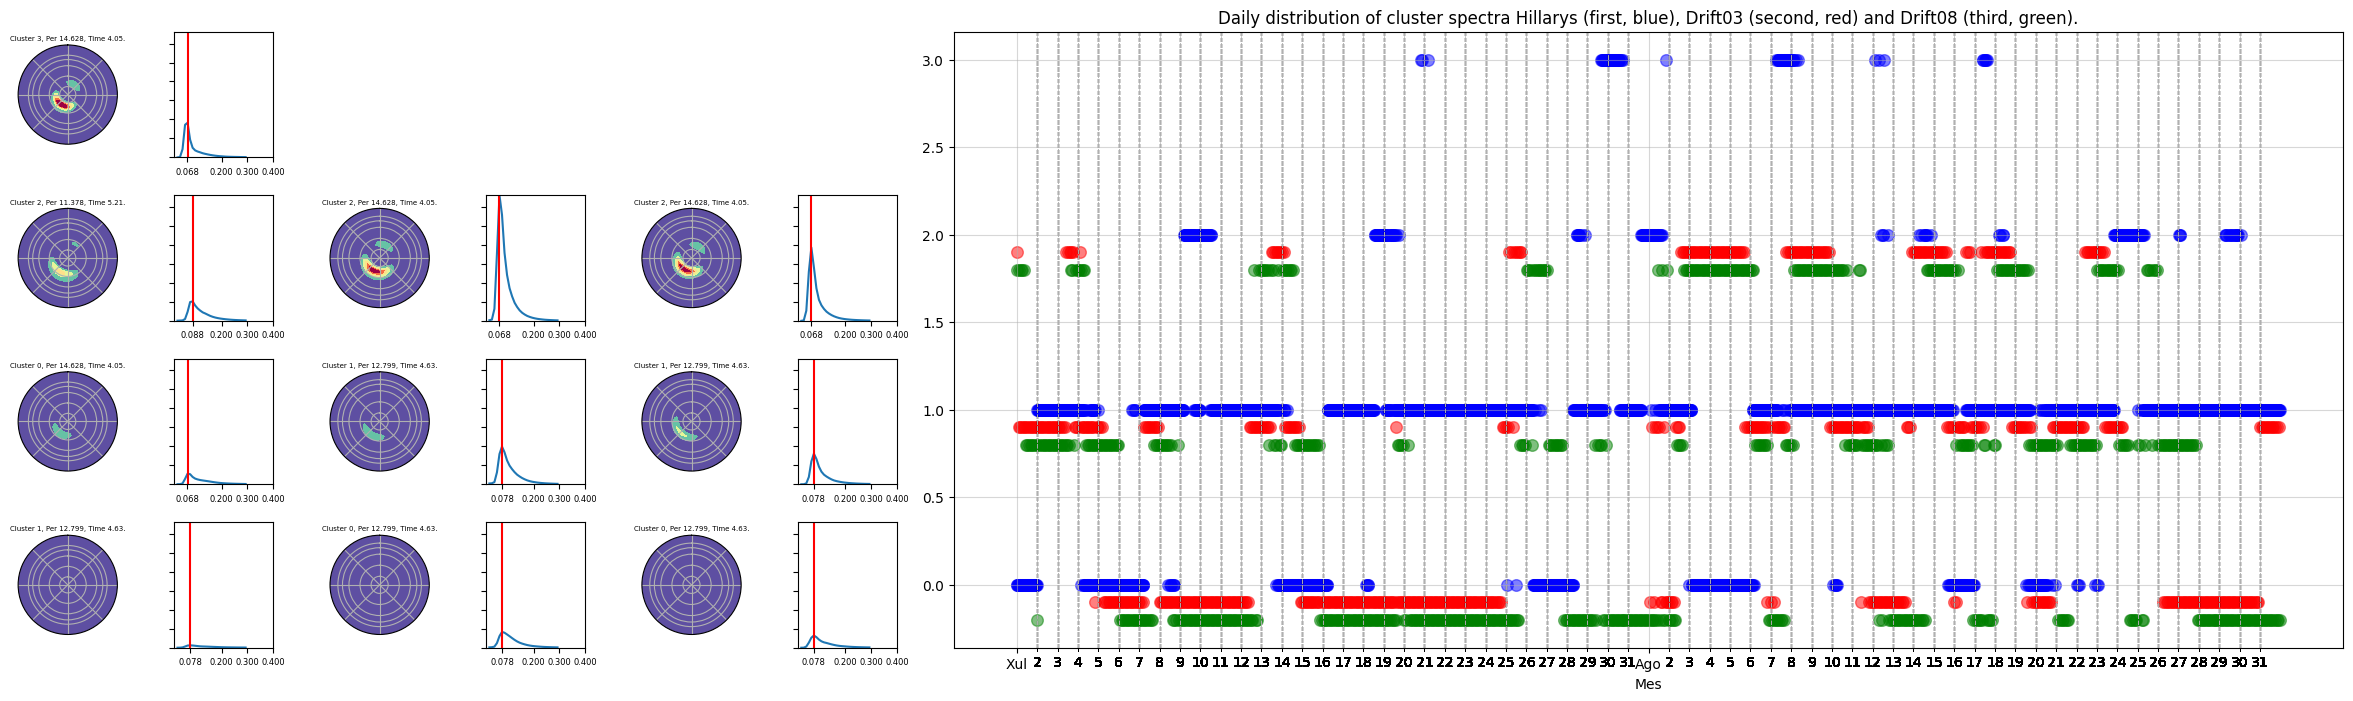

In [32]:
plot_cluster_spectrum_and_timeline_list([df_hillarys, df_drift03, df_drift06], [efth_ordered_hillarys, efth_ordered_drift03, efth_ordered_drift06], [n_clusters_hillarys_ord, n_clusters_drift03_ord, n_clusters_drift06_ord], title="Hillarys (first, blue), Drift03 (second, red) and Drift08 (third, green).", save="Buoy_cluster_comparison.png")

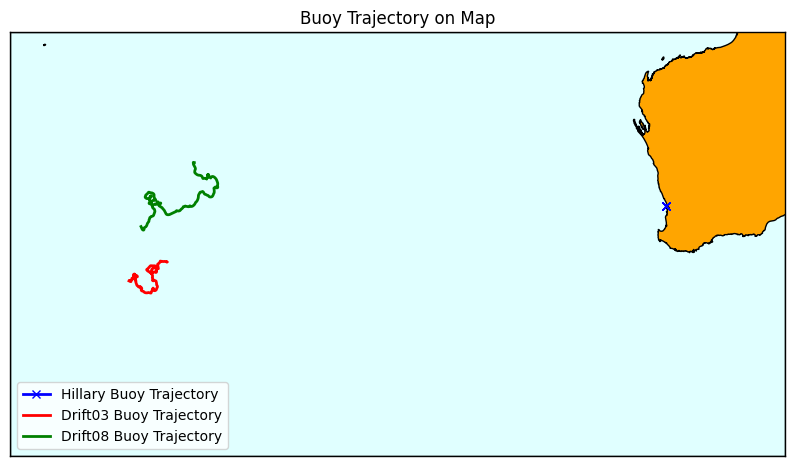

In [33]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

lon_h = np.concatenate([np.array(f_hillary.get('SpotData/lon')), np.array(f_hillary_2.get('SpotData/lon'))], axis=1)[0]
lat_h = np.concatenate([np.array(f_hillary.get('SpotData/lat')), np.array(f_hillary_2.get('SpotData/lat'))], axis=1)[0]
lon_d03 = np.concatenate([np.array(f_drift03.get('SpotData/lon')), np.array(f_drift03_2.get('SpotData/lon'))], axis=1)[0]
lat_d03 = np.concatenate([np.array(f_drift03.get('SpotData/lat')), np.array(f_drift03_2.get('SpotData/lat'))], axis=1)[0]
lon_d06 = np.concatenate([np.array(f_drift06.get('SpotData/lon')), np.array(f_drift06_2.get('SpotData/lon'))], axis=1)[0]
lat_d06 = np.concatenate([np.array(f_drift06.get('SpotData/lat')), np.array(f_drift06_2.get('SpotData/lat'))], axis=1)[0]


min_lat = np.min(np.concatenate([lat_h, lat_d03, lat_d06]))
max_lat = np.max(np.concatenate([lat_h, lat_d03, lat_d06]))
min_lon = np.min(np.concatenate([lon_h, lon_d03, lon_d06]))
max_lon = np.max(np.concatenate([lon_h, lon_d03, lon_d06]))

plt.figure(figsize=(10, 8))
m = Basemap(projection='merc',
            llcrnrlat=min_lat-10.0, urcrnrlat=max_lat+10.0,
            llcrnrlon=min_lon-10.0, urcrnrlon=max_lon+10.0,
            resolution='i')

m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='orange', lake_color='aqua')
m.drawmapboundary(fill_color='lightcyan')

x, y = m(lon_h, lat_h)
m.plot(x, y, marker='x', color='b', linewidth=2.0, label='Hillary Buoy Trajectory')
x, y = m(lon_d03, lat_d03)
m.plot(x, y, color='r', linewidth=2.0, label='Drift03 Buoy Trajectory')
x, y = m(lon_d06, lat_d06)
m.plot(x, y, color='g', linewidth=2.0, label='Drift08 Buoy Trajectory')
plt.title('Buoy Trajectory on Map')
plt.legend()
plt.savefig('/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/map.png')
plt.show()


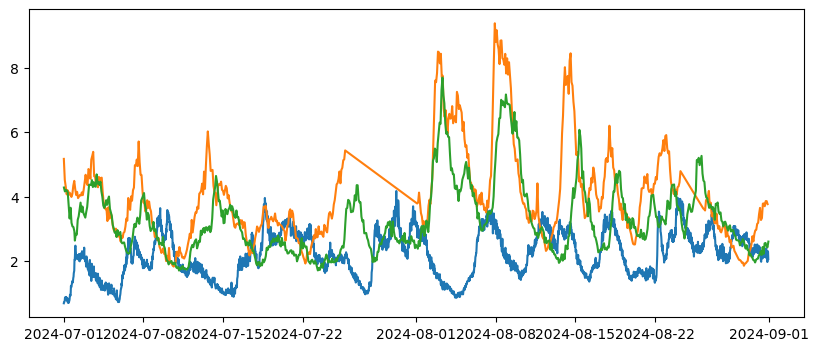

In [34]:
fig = plt.figure(figsize=(10,4))
plt.plot(data_time_hillarys, hs_h)
plt.plot(data_time_drift03, hs_d03)
plt.plot(data_time_drift06, hs_d06)

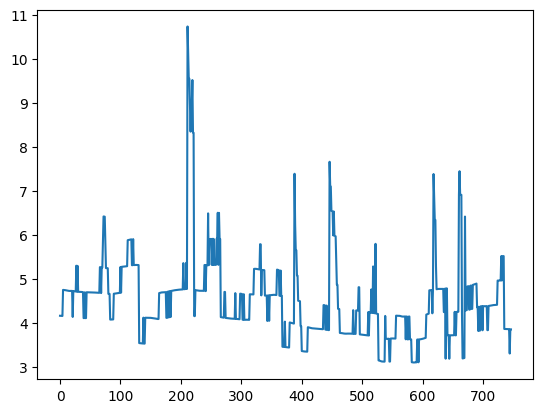

In [35]:
#Distance function
from math import radians, sin, cos, sqrt, asin


def distance_in_km(lon1, lat1, lon2, lat2):
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return r * c


import numpy as np
from math import radians, sin, cos, sqrt, asin, pi


def wave_travel_time(freqs, dirs, spectrum, lon1, lat1, lon2, lat2):
    # 1. Find max frequency and its main direction
    idx_freq = np.argmax(np.sum(spectrum, axis=1))  # index of max energy frequency
    idx_dir = np.argmax(spectrum[idx_freq])  # index of max energy direction for that freq
    max_freq = freqs[idx_freq]
    main_dir = dirs[idx_dir] + 180  # degrees, oceanographic convention

    # 2. Calculate straight-line distance between points (Haversine)
    def haversine(lon1, lat1, lon2, lat2):
        lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
        c = 2 * asin(sqrt(a))
        r = 6371  # km
        return r * c

    dist = haversine(lon1, lat1, lon2, lat2)

    # 3. Compute wave speed (deep water Stokes wave approximation)
    g = 9.81  # m/s^2
    wave_speed = (g / (4 * pi * max_freq)) / 1000 * 3600  # km/h

    # 4. Compute travel time
    if wave_speed > 0:
        travel_time = abs(dist) / wave_speed  # seconds
        travel_time = travel_time / 24.0
    else:
        travel_time = np.nan

    return travel_time


trav_time_drift06 = np.array([wave_travel_time(freq, directions, d, lon, lat, lon_h[0], lat_h[0]) for d, lon, lat in
                              zip(data_drifting06, lon_d06, lat_d06)])
plt.plot(trav_time_drift06)

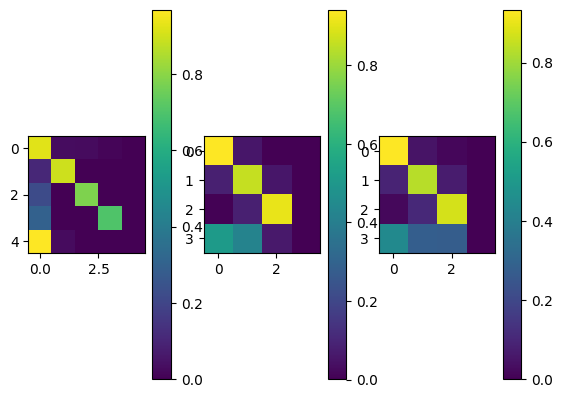

In [36]:
fig, ax = plt.subplots(1,3)
im1 = ax[0].imshow(sw_gp_hillary.compute_Pi())
im2 = ax[1].imshow(sw_gp_drift03.compute_Pi())
im3 = ax[2].imshow(sw_gp_drift06.compute_Pi())
plt.colorbar(im1, ax=ax[0])
plt.colorbar(im2, ax=ax[1])
plt.colorbar(im3, ax=ax[2])
plt.show()


In [37]:
from hdpgpc import buoy_utils
from datetime import datetime, timedelta
plot = False
with open('arrival_estimations.txt', 'w') as f:
    for d in range(0, 60 * 24, 6):
        time_select_datetime = datetime(2024, 7, 1, 0) + timedelta(days=d)
        fractional_day = (time_select_datetime.hour * 3600 + time_select_datetime.minute * 60 + time_select_datetime.second) / 86400.0
        time_select_ordinal = datetime.toordinal(time_select_datetime + timedelta(days = 366)) + fractional_day
        index_hillary = np.argmin(np.abs(spec_time_hillarys - time_select_ordinal))
        index_hillary_dp = np.argmin(np.abs(time_hillarys - time_select_ordinal))
        index_drift03 = np.argmin(np.abs(spec_time_drift03 - time_select_ordinal))
        index_drift03_dp = np.argmin(np.abs(time_drift03 - time_select_ordinal))
        index_drift06 = np.argmin(np.abs(spec_time_drift06 - time_select_ordinal))
        index_drift06_dp = np.argmin(np.abs(time_drift06 - time_select_ordinal))
        #time_select_datetime = datetime.fromordinal(int(time_select)) + timedelta(days=int(time_select%1)) - timedelta(days = 366)
        #time_select_datetime = time_select_datetime - timedelta(days=8)

        if plot:
            fig, ax = buoy_utils.plot_directional_spectrum(frequencies_drift03, directions_drift03, data_drifting03[index_drift03],
                                                    title='Drift 03 Buoy - Directional Spectrum of time '+ str(time_select_datetime))
            fig, ax = buoy_utils.plot_directional_spectrum(frequencies_drift06, directions_drift06, data_drifting06[index_drift06],
                                                    title='Drift 06 Buoy - Directional Spectrum of time '+ str(time_select_datetime))
            plt.show()

        hsig_h = np.concatenate([np.array(f_hillary.get('SpotData/hsig')), np.array(f_hillary_2.get('SpotData/hsig'))], axis=1)
        dp_h = np.concatenate([np.array(f_hillary.get('SpotData/dp')), np.array(f_hillary_2.get('SpotData/dp'))], axis=1)
        peak_freq_h = frequencies_hillarys[np.argmax(np.sum(data[index_hillary], axis=1))]
        peak_energy_h = np.max(data[index_hillary])
        spread_h_ = np.concatenate([np.array(f_hillary.get('SpotData/directionalSpread')), np.array(f_hillary_2.get('SpotData/directionalSpread'))], axis=1)
        spread_h = spread_h_[np.argmax(np.sum(data[index_hillary], axis=1)), index_hillary_dp]

        hsig_d03 = np.concatenate([np.array(f_drift03.get('SpotData/hsig')), np.array(f_drift03_2.get('SpotData/hsig'))], axis=1)
        dp_d03 = np.concatenate([np.array(f_drift03.get('SpotData/dp')), np.array(f_drift03_2.get('SpotData/dp'))], axis=1)
        peak_freq_d03 = frequencies_drift03[np.argmax(np.sum(data_drifting03[index_drift03], axis=1))]
        peak_energy_d03 = np.max(data_drifting03[index_drift03])
        spread_d03_ = np.concatenate([np.array(f_drift03.get('SpotData/directionalSpread')), np.array(f_drift03_2.get('SpotData/directionalSpread'))], axis=1)
        spread_d03 = spread_d03_[np.argmax(np.sum(data_drifting03[index_drift03], axis=1)), index_drift03_dp]

        hsig_d08 = np.concatenate([np.array(f_drift06.get('SpotData/hsig')), np.array(f_drift06_2.get('SpotData/hsig'))], axis=1)
        dp_d08 = np.concatenate([np.array(f_drift06.get('SpotData/dp')), np.array(f_drift06_2.get('SpotData/dp'))], axis=1)
        peak_freq_d08 = frequencies_drift06[np.argmax(np.sum(data_drifting06[index_drift06], axis=1))]
        peak_energy_d08 = np.max(data_drifting06[index_drift06])
        spread_d06_ = np.concatenate([np.array(f_drift06.get('SpotData/directionalSpread')), np.array(f_drift06_2.get('SpotData/directionalSpread'))], axis=1)
        spread_d06 = spread_d06_[np.argmax(np.sum(data_drifting06[index_drift06], axis=1)), index_drift06_dp]

        time_d03 = datetime.fromordinal(int(spec_time_drift03[:, index_drift03])) + timedelta(days=int(spec_time_drift03[:, index_drift03]%1)) - timedelta(days = 366)
        time_d08 = datetime.fromordinal(int(spec_time_drift06[:, index_drift06])) + timedelta(days=int(spec_time_drift06[:, index_drift06]%1)) - timedelta(days = 366)

        obs_d03 = buoy_utils.BuoyObservation(lat_d03[index_drift03], lon_d03[index_drift03], time_d03, data_drifting03[index_drift03], peak_freq_d03, dp_d03[:,index_drift03_dp], peak_energy_d03, spread_d03)
        obs_d08 = buoy_utils.BuoyObservation(lat_d06[index_drift03], lon_d06[index_drift03], time_d08, data_drifting06[index_drift06], peak_freq_d08, dp_d08[:,index_drift06_dp], peak_energy_d08, spread_d06)

        triangulation = buoy_utils.SwellBackTriangulation(obs_d03, obs_d08, [lat_h[0], lon_h[0]])
        source = triangulation.triangulate_source_location(method='weighted_centroid')

        arrival = triangulation.predict_coastal_arrival(source)

        time_arrival_ordinal = datetime.toordinal(arrival['arrival_time'] + timedelta(days = 366))
        index_hillary_arrival = np.argmin(np.abs(spec_time_hillarys - time_arrival_ordinal))
        index_hillary_dp_arrival = np.argmin(np.abs(time_hillarys - time_arrival_ordinal))
        peak_freq_h_arrival = frequencies_hillarys[np.argmax(np.sum(data[index_hillary_arrival], axis=1))]
        peak_energy_h_arrival = np.max(data[index_hillary_arrival])
        if plot:
            fig, ax = buoy_utils.plot_directional_spectrum(frequencies_hillarys, directions_hillarys, data_[index_hillary_arrival],
                                                    title='Hillary Buoy - Directional Spectrum of estimated arrival time '+ str(arrival['arrival_time']))

        print("\n-------Time event on drifts: " + str(time_select_datetime) + "--------", file=f)
        print("  Estimated time of source ", file=f)
        print("   " + str(arrival['source_generation_time']), file=f)
        print("  Arrival time and uncertainty", file=f)
        print("   " + str(arrival['arrival_time']), file=f)
        print("    --> Estimated spectral quantities:", file=f)
        print('        Estimated energy ' + str(arrival['arrival_energy'].item()) + ' vs real ' + str(peak_energy_h_arrival), file=f)
        print('        Estimated frequency ' + str(arrival['arrival_frequency'].values) + ' vs real ' + str(peak_freq_h_arrival.values), file=f)
        print('        Estimated direction '+ str(arrival['arrival_direction'].item()) + ' vs real ' + str(dp_h[:, index_hillary_dp_arrival].item()), file=f)

/tmp/ipykernel_2451923/2339648591.py:46: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2339648591.py:47: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2339648591.py:46: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2339648591.py:47: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array befo

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/hdpgpc/buoy_utils.py:287: UserWarning:

Buoy observations are 24.00 hours apart




-------Time event on drifts: 2024-07-12 00:00:00--------
  Estimated time of source
   2024-07-09 08:36:19.557532
  Arrival time and uncertainty
   2024-07-14 05:36:19.557532
    --> Estimated spectral quantities:
     Estimated energy 3.136564712715698 vs real 1.113495735375471
     Estimated frequency 0.05859 vs real 0.07813
     Estimated direction 255.86676157958172 vs real 247.154


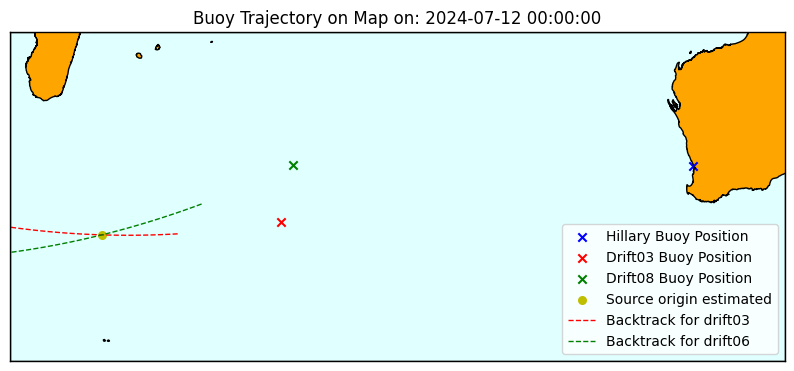

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-12 06:00:00--------
  Estimated time of source
   2024-07-09 08:36:19.557532
  Arrival time and uncertainty
   2024-07-15 01:36:19.557532
    --> Estimated spectral quantities:
     Estimated energy 6.051548869503154 vs real 0.5397565432977962
     Estimated frequency 0.05859 vs real 0.07813
     Estimated direction 257.3294456125913 vs real 253.562


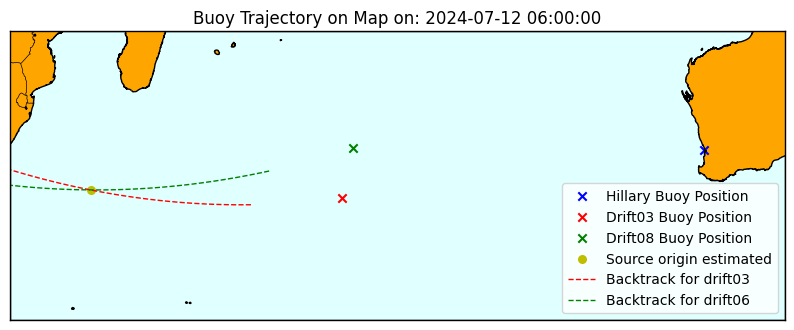

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-12 12:00:00--------
  Estimated time of source
   2024-07-08 22:02:03.341063
  Arrival time and uncertainty
   2024-07-17 07:02:03.341063
    --> Estimated spectral quantities:
     Estimated energy 0.0 vs real 3.7193337645762163
     Estimated frequency 0.06836 vs real 0.06836
     Estimated direction 254.16159610920425 vs real 252.151


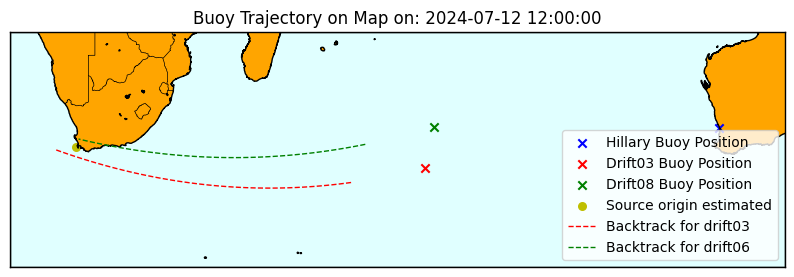

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-12 18:00:00--------
  Estimated time of source
   2024-07-08 22:02:03.341063
  Arrival time and uncertainty
   2024-07-17 06:02:03.341063
    --> Estimated spectral quantities:
     Estimated energy 5.455176682366963 vs real 3.7193337645762163
     Estimated frequency 0.06836 vs real 0.06836
     Estimated direction 249.40889087564082 vs real 252.151


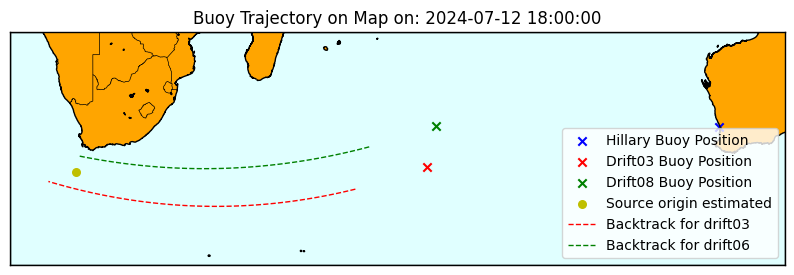

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/hdpgpc/buoy_utils.py:287: UserWarning:

Buoy observations are 24.00 hours apart




-------Time event on drifts: 2024-07-13 00:00:00--------
  Estimated time of source
   2024-07-09 22:02:03.341063
  Arrival time and uncertainty
   2024-07-16 23:02:03.341063
    --> Estimated spectral quantities:
     Estimated energy 6.997276714066193 vs real 0.6655473559530074
     Estimated frequency 0.06836 vs real 0.07813
     Estimated direction 250.857442169046 vs real 258.064


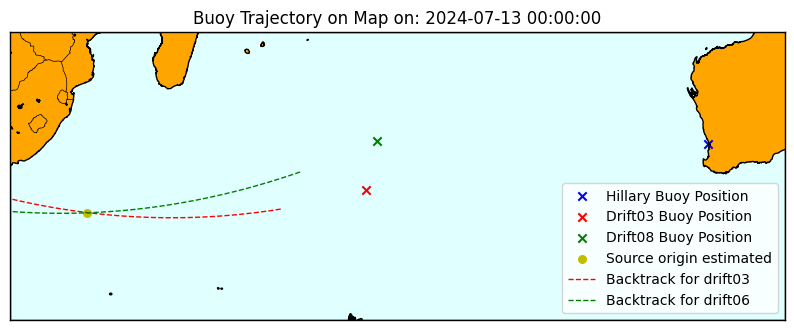

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-13 06:00:00--------
  Estimated time of source
   2024-07-09 22:02:03.341063
  Arrival time and uncertainty
   2024-07-16 15:02:03.341063
    --> Estimated spectral quantities:
     Estimated energy 7.044666047636896 vs real 0.6655473559530074
     Estimated frequency 0.06836 vs real 0.07813
     Estimated direction 249.12120073314213 vs real 258.064


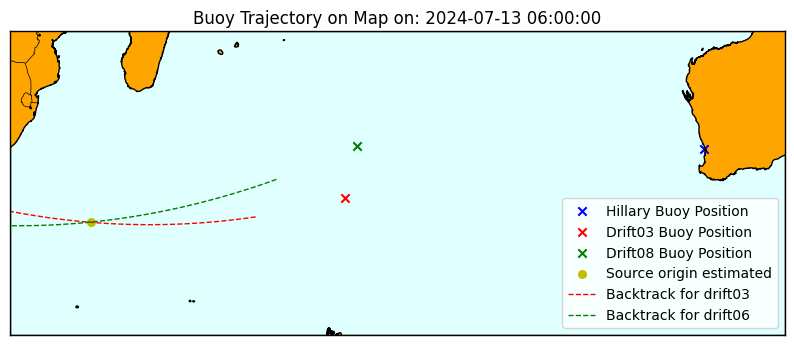

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-13 12:00:00--------
  Estimated time of source
   2024-07-09 11:27:47.124594
  Arrival time and uncertainty
   2024-07-14 09:27:47.124594
    --> Estimated spectral quantities:
     Estimated energy 9.302986049315429 vs real 1.113495735375471
     Estimated frequency 0.073245 vs real 0.07813
     Estimated direction 237.7376825562987 vs real 247.154


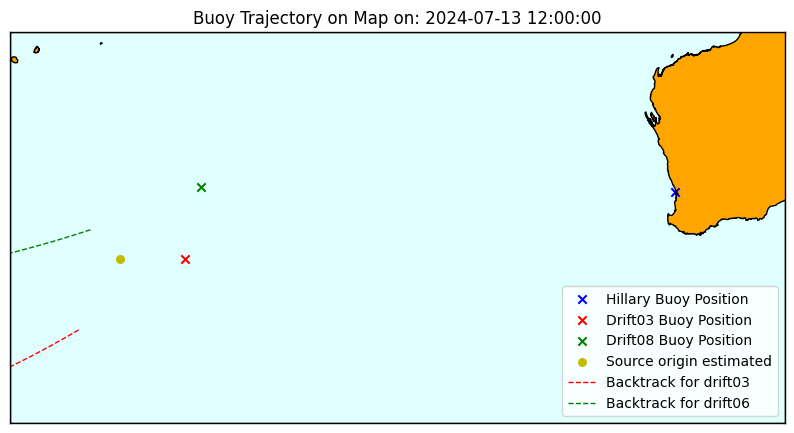

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-13 18:00:00--------
  Estimated time of source
   2024-07-09 22:02:03.341063
  Arrival time and uncertainty
   2024-07-14 10:02:03.341063
    --> Estimated spectral quantities:
     Estimated energy 13.18660585154102 vs real 1.113495735375471
     Estimated frequency 0.06836 vs real 0.07813
     Estimated direction 234.85323021412887 vs real 247.154


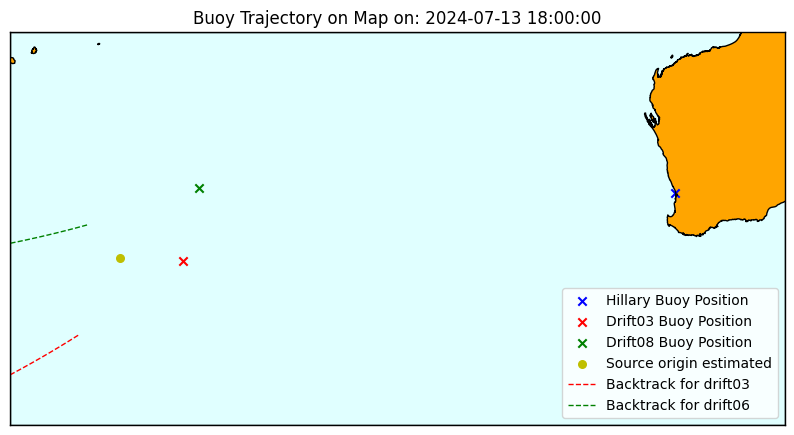

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/hdpgpc/buoy_utils.py:287: UserWarning:

Buoy observations are 24.00 hours apart




-------Time event on drifts: 2024-07-14 00:00:00--------
  Estimated time of source
   2024-07-10 11:27:47.124594
  Arrival time and uncertainty
   2024-07-15 09:27:47.124594
    --> Estimated spectral quantities:
     Estimated energy 8.630141777887172 vs real 0.5397565432977962
     Estimated frequency 0.073245 vs real 0.07813
     Estimated direction 236.94452235005872 vs real 253.562


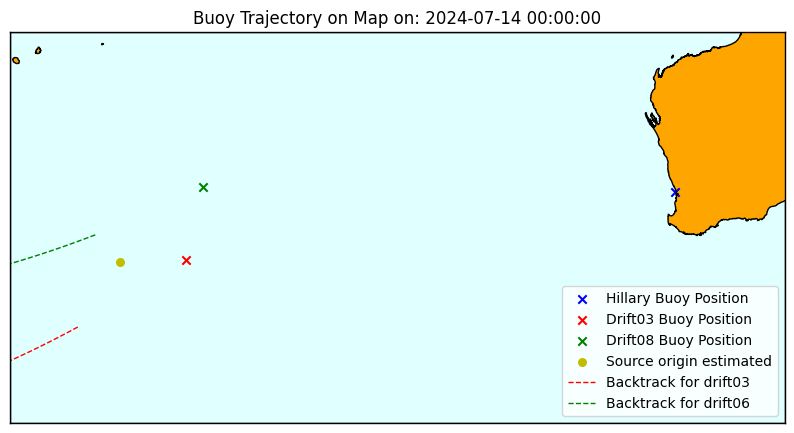

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-14 06:00:00--------
  Estimated time of source
   2024-07-10 11:27:47.124594
  Arrival time and uncertainty
   2024-07-15 17:27:47.124594
    --> Estimated spectral quantities:
     Estimated energy 9.177440083434083 vs real 0.5397565432977962
     Estimated frequency 0.073245 vs real 0.07813
     Estimated direction 226.97861150066137 vs real 253.562


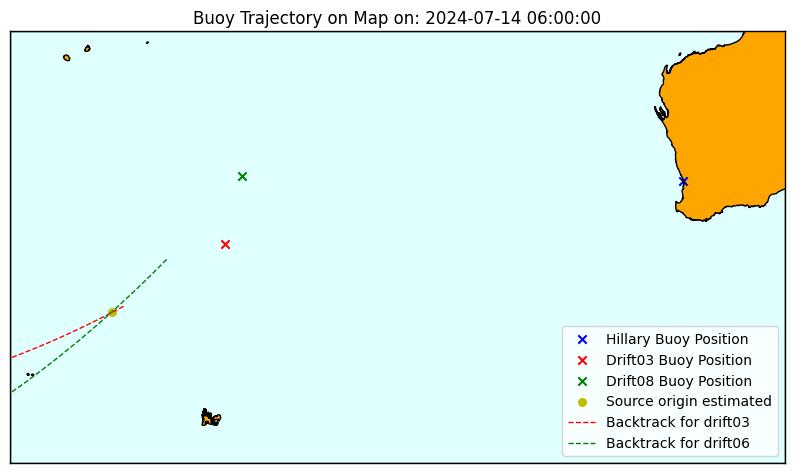

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-14 12:00:00--------
  Estimated time of source
   2024-07-10 11:27:47.124594
  Arrival time and uncertainty
   2024-07-17 15:27:47.124594
    --> Estimated spectral quantities:
     Estimated energy 9.380001080683 vs real 3.7193337645762163
     Estimated frequency 0.073245 vs real 0.06836
     Estimated direction 227.33703762743798 vs real 252.151


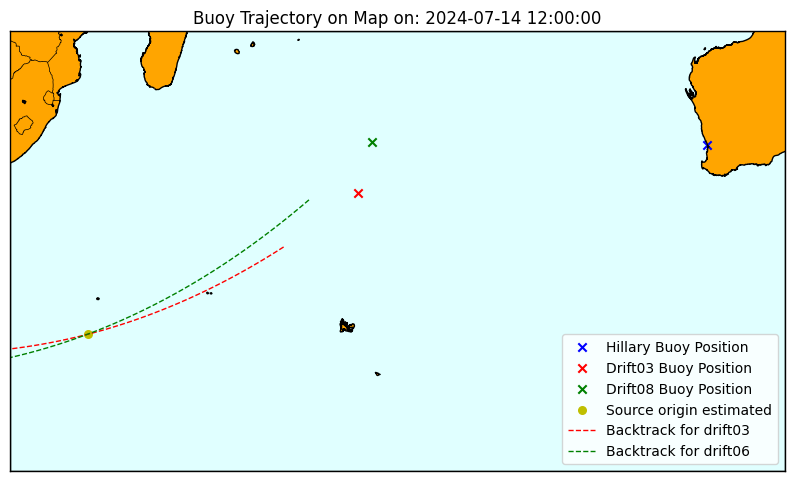

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-14 18:00:00--------
  Estimated time of source
   2024-07-10 11:27:47.124594
  Arrival time and uncertainty
   2024-07-15 02:27:47.124594
    --> Estimated spectral quantities:
     Estimated energy 0.0 vs real 0.5397565432977962
     Estimated frequency 0.07813 vs real 0.07813
     Estimated direction 218.31774657576207 vs real 253.562


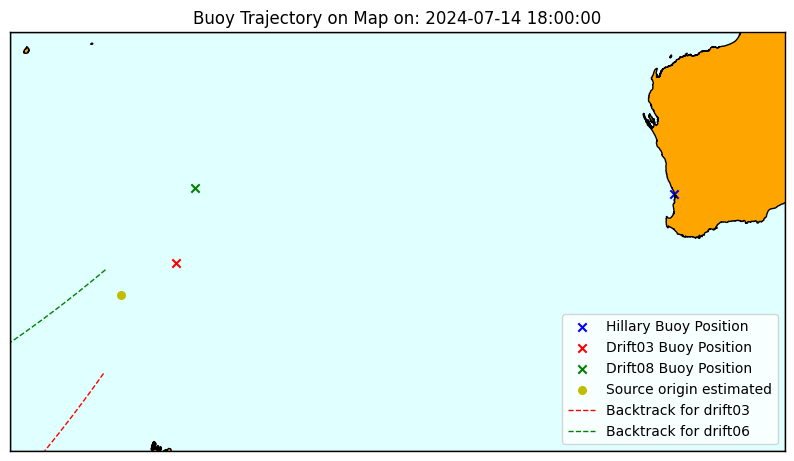

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/hdpgpc/buoy_utils.py:287: UserWarning:

Buoy observations are 24.00 hours apart




-------Time event on drifts: 2024-07-15 00:00:00--------
  Estimated time of source
   2024-07-11 11:27:47.124594
  Arrival time and uncertainty
   2024-07-15 09:27:47.124594
    --> Estimated spectral quantities:
     Estimated energy 0.0 vs real 0.5397565432977962
     Estimated frequency 0.07813 vs real 0.07813
     Estimated direction 207.20426091189347 vs real 253.562


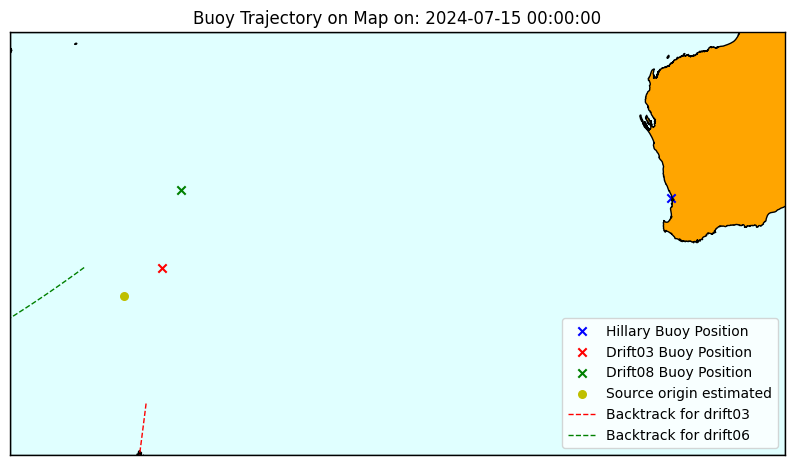

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-15 06:00:00--------
  Estimated time of source
   2024-07-11 11:27:47.124594
  Arrival time and uncertainty
   2024-07-14 03:27:47.124594
    --> Estimated spectral quantities:
     Estimated energy 0.0 vs real 1.113495735375471
     Estimated frequency 0.07813 vs real 0.07813
     Estimated direction 188.16075175433065 vs real 247.154


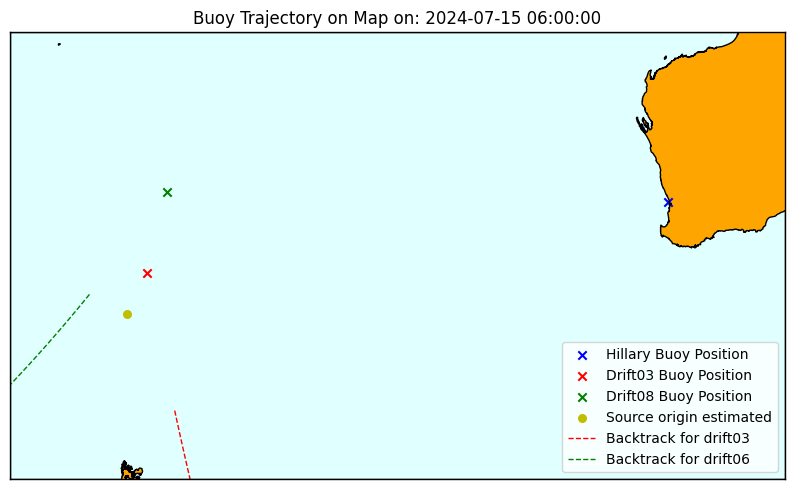

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-15 12:00:00--------
  Estimated time of source
   2024-07-11 11:27:47.124594
  Arrival time and uncertainty
   2024-07-13 10:27:47.124594
    --> Estimated spectral quantities:
     Estimated energy 0.0 vs real 2.6063001674665163
     Estimated frequency 0.07813 vs real 0.06836
     Estimated direction 178.3923549894158 vs real 252.309


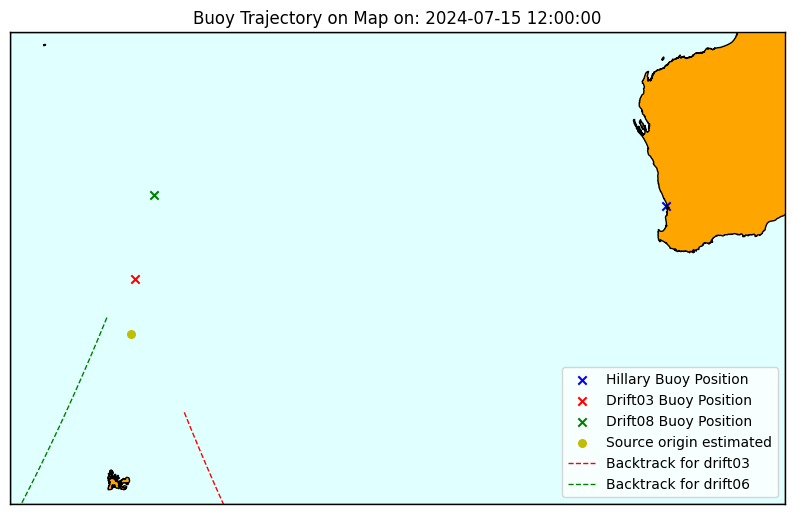

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-15 18:00:00--------
  Estimated time of source
   2024-07-11 11:27:47.124594
  Arrival time and uncertainty
   2024-07-12 20:27:47.124594
    --> Estimated spectral quantities:
     Estimated energy 0.0 vs real 1.8718938840837687
     Estimated frequency 0.073245 vs real 0.07813
     Estimated direction 171.49983010746266 vs real 253.489


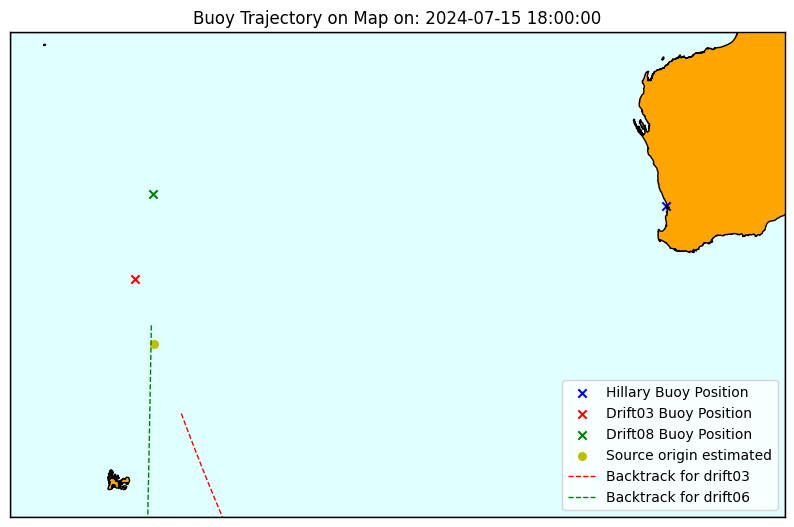

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/hdpgpc/buoy_utils.py:287: UserWarning:

Buoy observations are 24.00 hours apart




-------Time event on drifts: 2024-07-16 00:00:00--------
  Estimated time of source
   2024-07-12 11:27:47.124594
  Arrival time and uncertainty
   2024-07-13 12:27:47.124594
    --> Estimated spectral quantities:
     Estimated energy 0.0 vs real 2.6063001674665163
     Estimated frequency 0.07813 vs real 0.06836
     Estimated direction 164.58302356123716 vs real 252.309


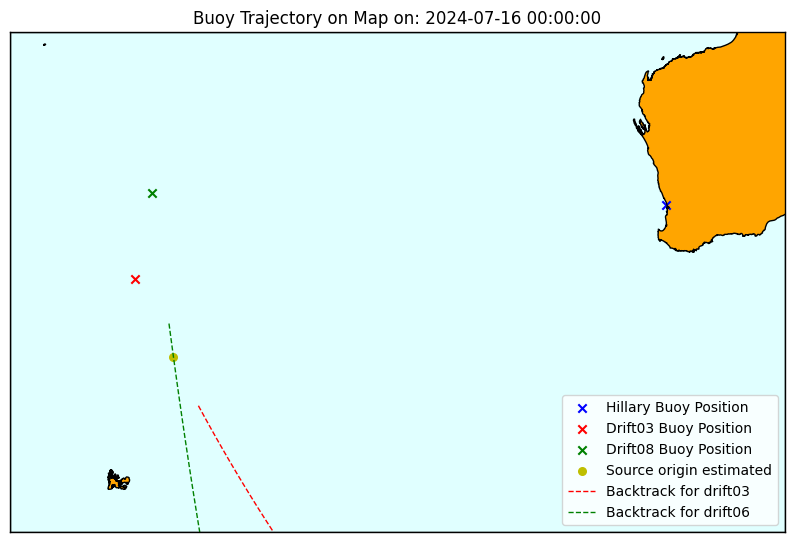

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-16 06:00:00--------
  Estimated time of source
   2024-07-12 00:54:09.860240
  Arrival time and uncertainty
   2024-07-16 12:54:09.860240
    --> Estimated spectral quantities:
     Estimated energy 0.0 vs real 0.6655473559530074
     Estimated frequency 0.08301 vs real 0.07813
     Estimated direction 168.6302965266176 vs real 258.064


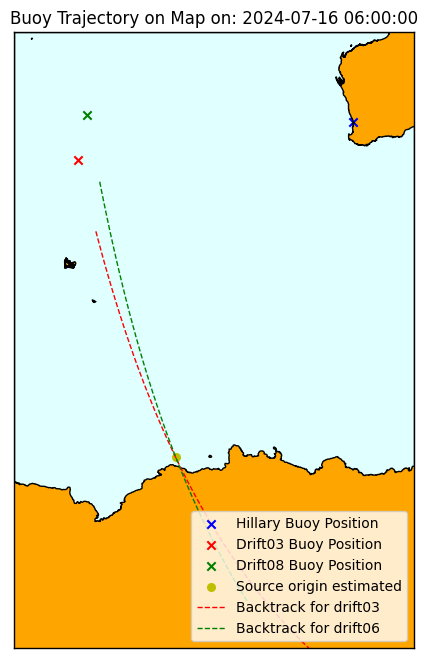

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-16 12:00:00--------
  Estimated time of source
   2024-07-12 11:27:47.124594
  Arrival time and uncertainty
   2024-07-13 15:27:47.124594
    --> Estimated spectral quantities:
     Estimated energy 0.0 vs real 2.6063001674665163
     Estimated frequency 0.07813 vs real 0.06836
     Estimated direction 168.51486799423444 vs real 252.309


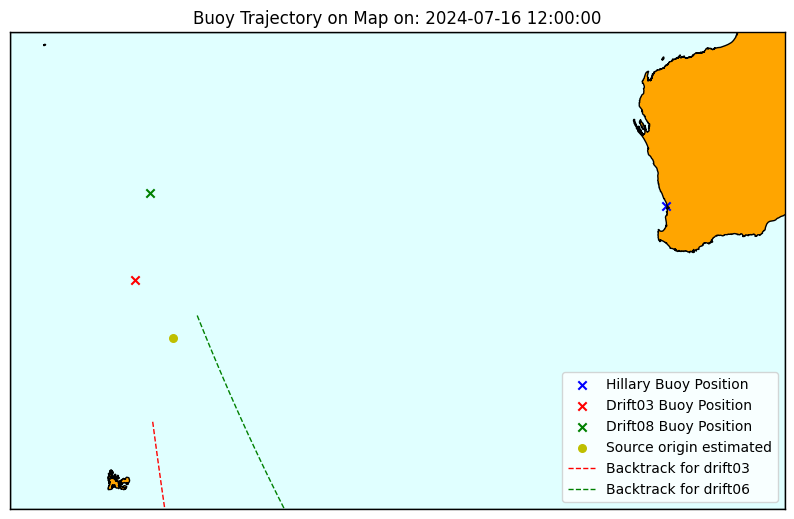

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-16 18:00:00--------
  Estimated time of source
   2024-07-12 11:27:47.124594
  Arrival time and uncertainty
   2024-07-14 08:27:47.124594
    --> Estimated spectral quantities:
     Estimated energy 0.0 vs real 1.113495735375471
     Estimated frequency 0.07813 vs real 0.07813
     Estimated direction 178.95538403384865 vs real 247.154


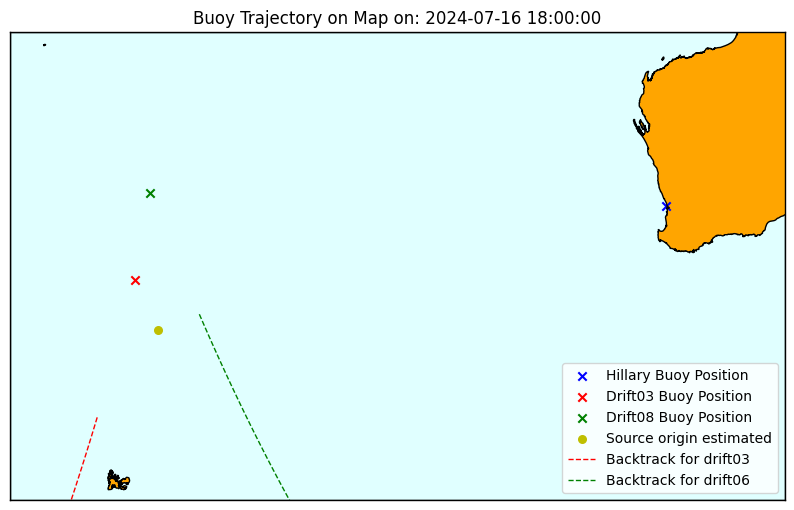

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-17 00:00:00--------
  Estimated time of source
   2024-07-13 11:27:47.124594
  Arrival time and uncertainty
   2024-07-15 01:27:47.124594
    --> Estimated spectral quantities:
     Estimated energy 0.0 vs real 0.5397565432977962
     Estimated frequency 0.07813 vs real 0.07813
     Estimated direction 174.56588422780348 vs real 253.562


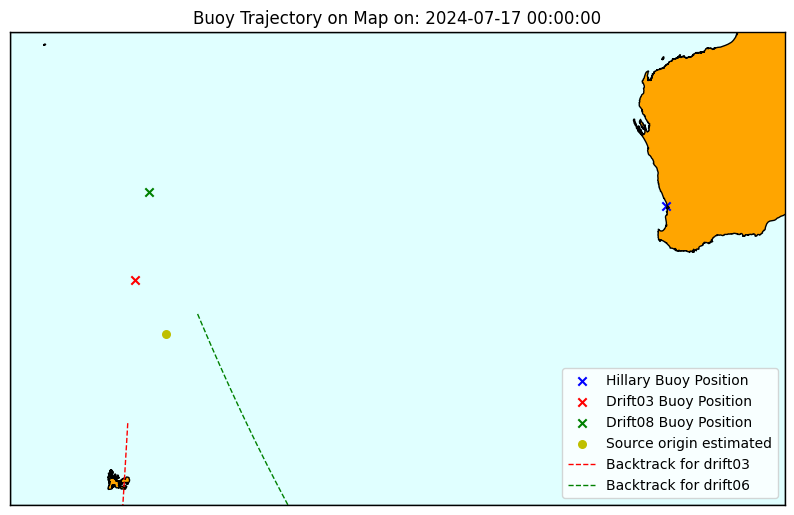

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-17 06:00:00--------
  Estimated time of source
   2024-07-13 11:27:47.124594
  Arrival time and uncertainty
   2024-07-15 08:27:47.124594
    --> Estimated spectral quantities:
     Estimated energy 0.0 vs real 0.5397565432977962
     Estimated frequency 0.07813 vs real 0.07813
     Estimated direction 177.05483370517356 vs real 253.562


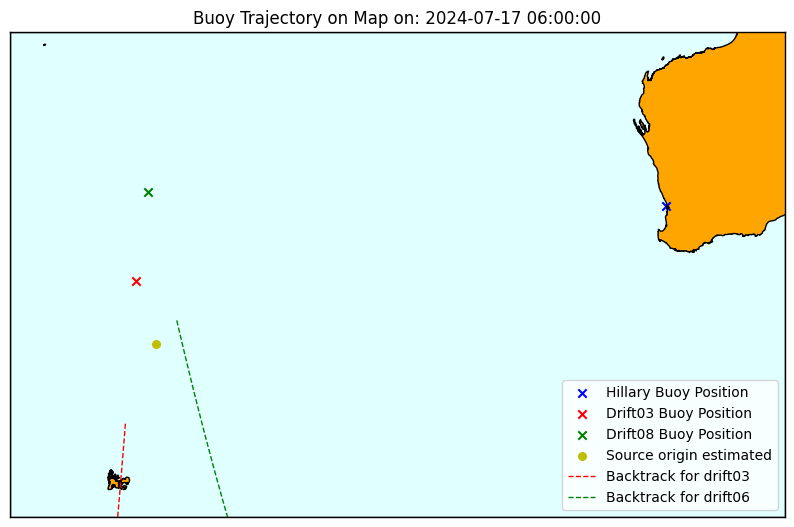

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-17 12:00:00--------
  Estimated time of source
   2024-07-13 11:27:47.124594
  Arrival time and uncertainty
   2024-07-15 08:27:47.124594
    --> Estimated spectral quantities:
     Estimated energy 0.0 vs real 0.5397565432977962
     Estimated frequency 0.07813 vs real 0.07813
     Estimated direction 176.35319448356782 vs real 253.562


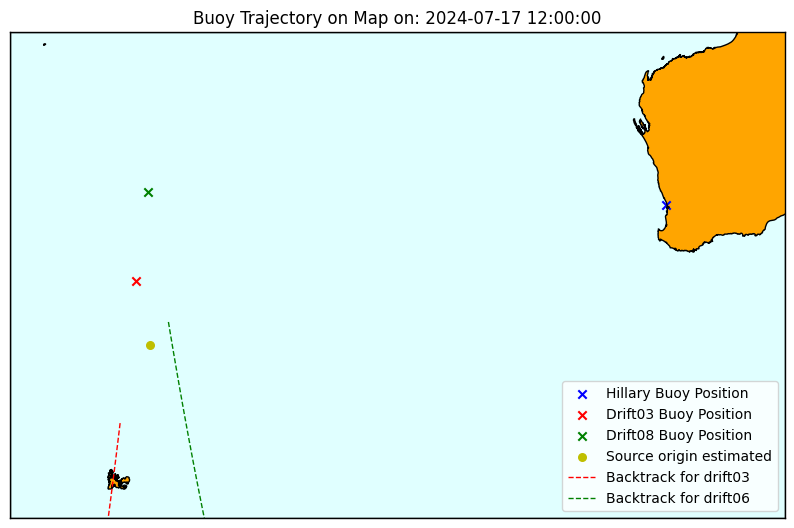

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-17 18:00:00--------
  Estimated time of source
   2024-07-09 22:56:13.201303
  Arrival time and uncertainty
   2024-07-13 11:56:13.201303
    --> Estimated spectral quantities:
     Estimated energy 0.0 vs real 2.6063001674665163
     Estimated frequency 0.11719 vs real 0.06836
     Estimated direction 193.37369217390406 vs real 252.309


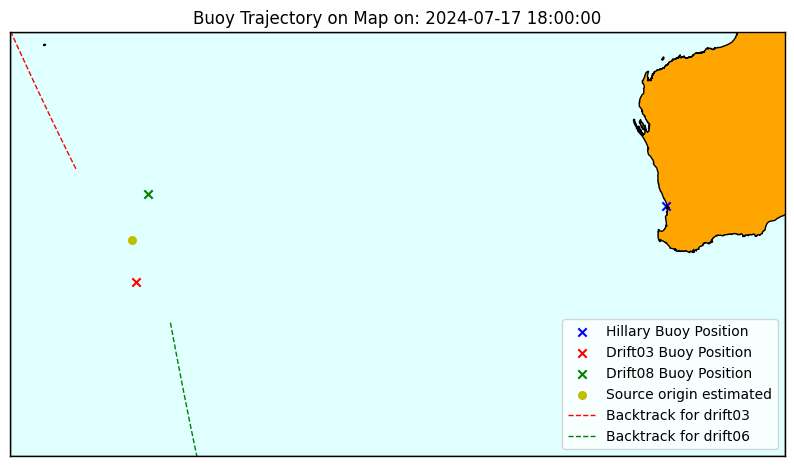

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-18 00:00:00--------
  Estimated time of source
   2024-07-12 06:38:22.898595
  Arrival time and uncertainty
   2024-07-14 11:38:22.898595
    --> Estimated spectral quantities:
     Estimated energy 0.0 vs real 1.113495735375471
     Estimated frequency 0.10254 vs real 0.07813
     Estimated direction 322.92039136152044 vs real 247.154


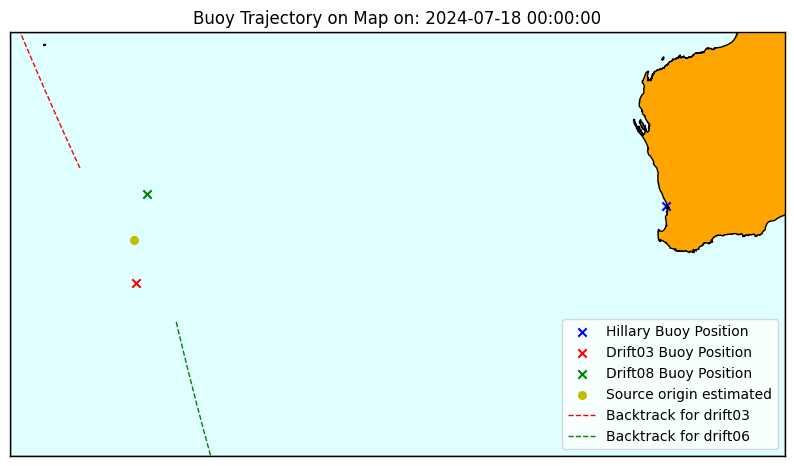

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-18 06:00:00--------
  Estimated time of source
   2024-07-12 17:12:00.162949
  Arrival time and uncertainty
   2024-07-15 05:12:00.162949
    --> Estimated spectral quantities:
     Estimated energy 0.0 vs real 0.5397565432977962
     Estimated frequency 0.09766 vs real 0.07813
     Estimated direction 318.9400075463291 vs real 253.562


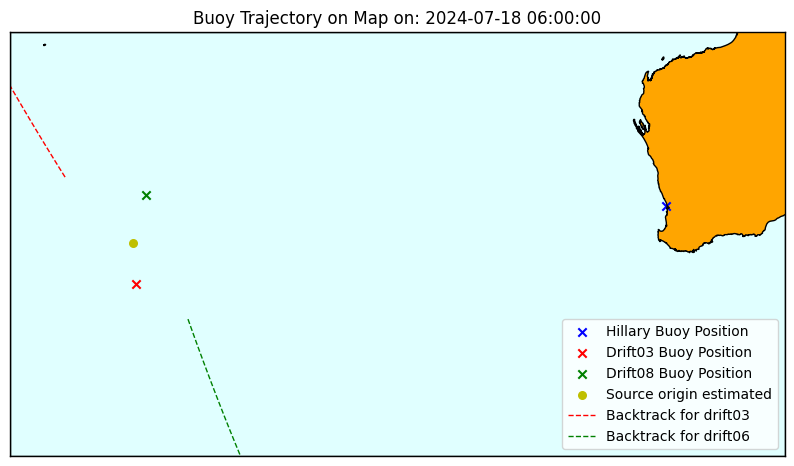

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-18 12:00:00--------
  Estimated time of source
   2024-07-12 17:12:00.162949
  Arrival time and uncertainty
   2024-07-15 13:12:00.162949
    --> Estimated spectral quantities:
     Estimated energy 0.0 vs real 0.5397565432977962
     Estimated frequency 0.146485 vs real 0.07813
     Estimated direction 334.9388994275571 vs real 253.562


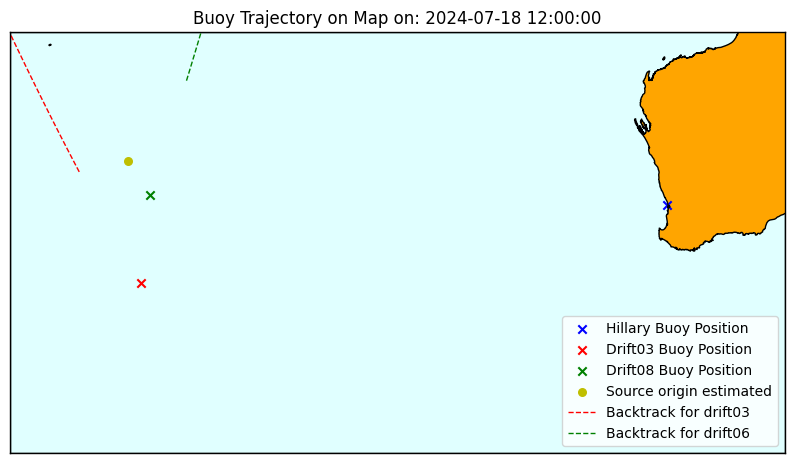

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-18 18:00:00--------
  Estimated time of source
   2024-07-13 03:46:16.379418
  Arrival time and uncertainty
   2024-07-16 03:46:16.379418
    --> Estimated spectral quantities:
     Estimated energy 0.0 vs real 0.6655473559530074
     Estimated frequency 0.131835 vs real 0.07813
     Estimated direction 329.86723259493186 vs real 258.064


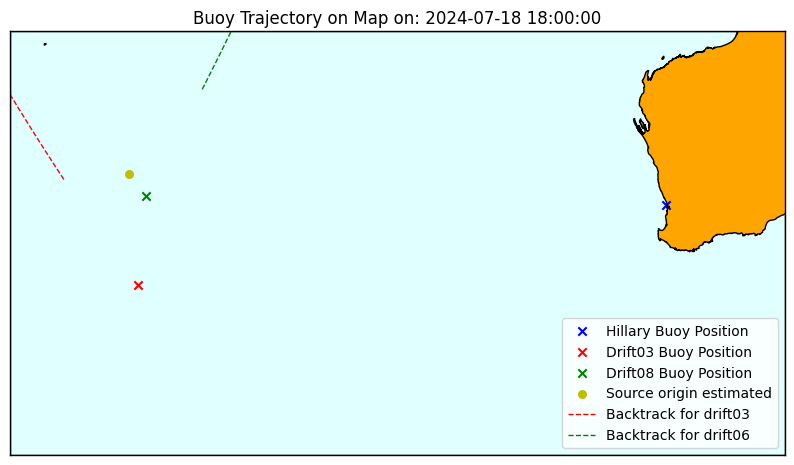

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-19 00:00:00--------
  Estimated time of source
   2024-07-14 03:46:16.379418
  Arrival time and uncertainty
   2024-07-14 19:46:16.379418
    --> Estimated spectral quantities:
     Estimated energy 0.0 vs real 1.113495735375471
     Estimated frequency 0.12695 vs real 0.07813
     Estimated direction 348.31302483194196 vs real 247.154


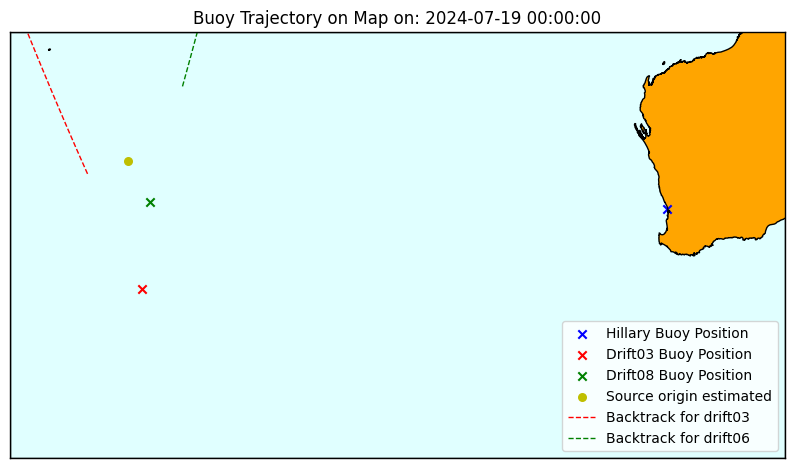

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-19 06:00:00--------
  Estimated time of source
   2024-07-15 11:27:47.124594
  Arrival time and uncertainty
   2024-07-22 02:27:47.124594
    --> Estimated spectral quantities:
     Estimated energy 2.9982520217330784 vs real 3.0236887457018997
     Estimated frequency 0.107425 vs real 0.06836
     Estimated direction 272.49303343744765 vs real 248.644


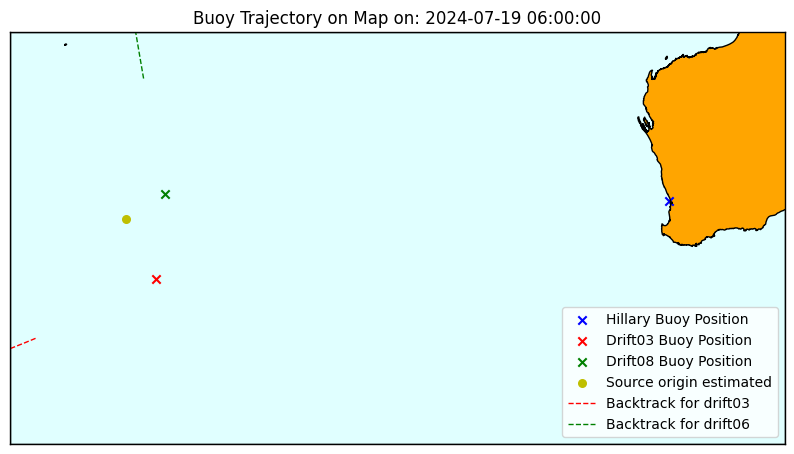

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-19 12:00:00--------
  Estimated time of source
   2024-07-15 11:27:47.124594
  Arrival time and uncertainty
   2024-07-22 14:27:47.124594
    --> Estimated spectral quantities:
     Estimated energy 3.3169377494436296 vs real 3.0236887457018997
     Estimated frequency 0.073245 vs real 0.06836
     Estimated direction 234.71118680137334 vs real 248.644


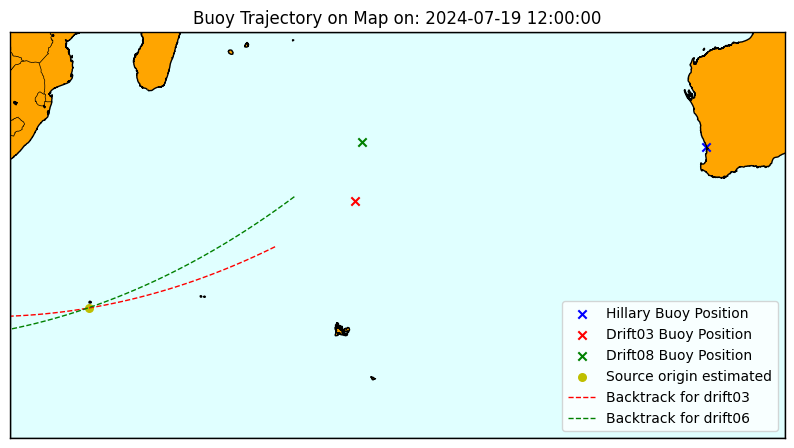

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-19 18:00:00--------
  Estimated time of source
   2024-07-15 11:27:47.124594
  Arrival time and uncertainty
   2024-07-24 17:27:47.124594
    --> Estimated spectral quantities:
     Estimated energy 4.285250874308752 vs real 2.082422413250001
     Estimated frequency 0.07813 vs real 0.07813
     Estimated direction 236.1253635578307 vs real 253.548


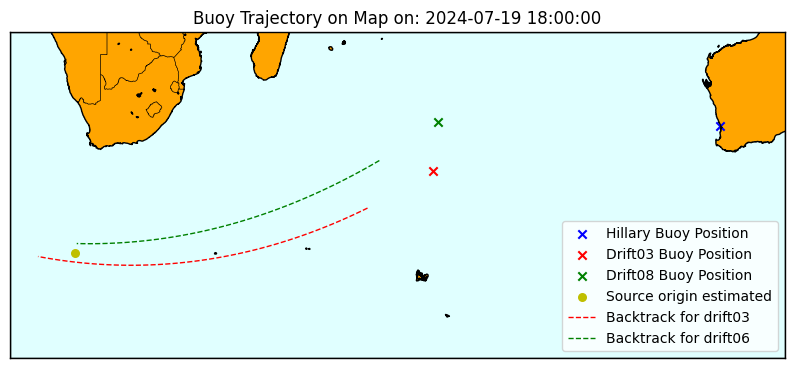

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-20 00:00:00--------
  Estimated time of source
   2024-07-16 00:54:09.860240
  Arrival time and uncertainty
   2024-07-23 10:54:09.860240
    --> Estimated spectral quantities:
     Estimated energy 3.3114531487375523 vs real 3.9332721476462025
     Estimated frequency 0.08301 vs real 0.06836
     Estimated direction 239.97730614812951 vs real 254.346


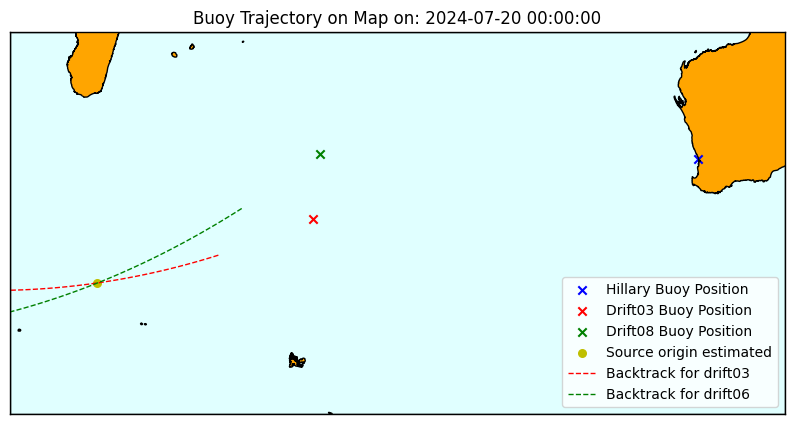

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-20 06:00:00--------
  Estimated time of source
   2024-07-16 00:54:09.860240
  Arrival time and uncertainty
   2024-07-25 12:54:09.860240
    --> Estimated spectral quantities:
     Estimated energy 2.6255190045752785 vs real 1.400291531776314
     Estimated frequency 0.08301 vs real 0.07813
     Estimated direction 227.72634401970907 vs real 252.602


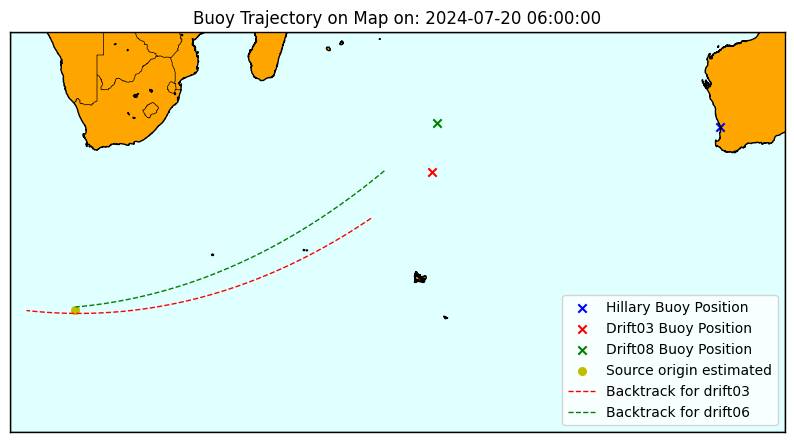

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-20 12:00:00--------
  Estimated time of source
   2024-07-16 00:54:09.860240
  Arrival time and uncertainty
   2024-07-24 06:54:09.860240
    --> Estimated spectral quantities:
     Estimated energy 2.0461718004137492 vs real 2.082422413250001
     Estimated frequency 0.08301 vs real 0.07813
     Estimated direction 234.77141019144108 vs real 253.548


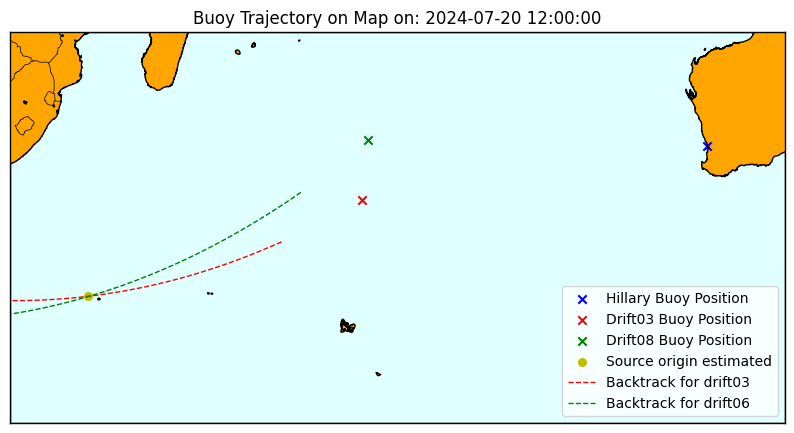

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-20 18:00:00--------
  Estimated time of source
   2024-07-15 14:19:53.643771
  Arrival time and uncertainty
   2024-07-20 15:19:53.643771
    --> Estimated spectral quantities:
     Estimated energy 0.0 vs real 4.309212776167406
     Estimated frequency 0.087895 vs real 0.06836
     Estimated direction 214.72716426934144 vs real 248.276


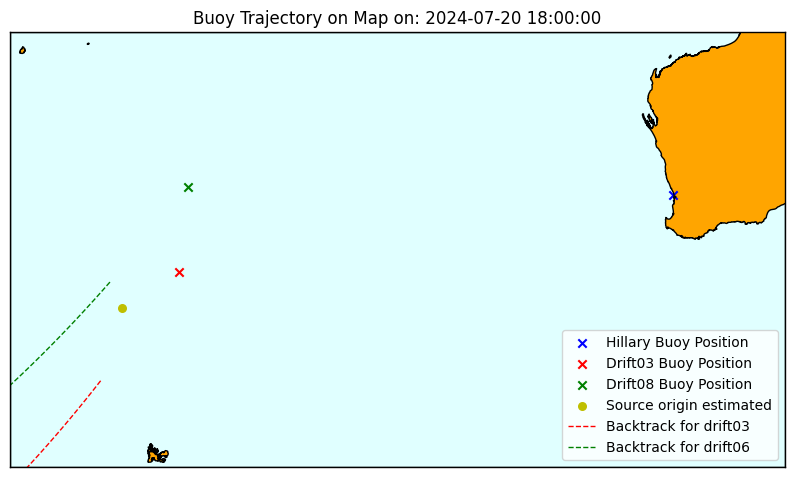

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-21 00:00:00--------
  Estimated time of source
   2024-07-16 14:19:53.643771
  Arrival time and uncertainty
   2024-07-20 13:19:53.643771
    --> Estimated spectral quantities:
     Estimated energy 0.0 vs real 4.309212776167406
     Estimated frequency 0.087895 vs real 0.06836
     Estimated direction 199.77666124037958 vs real 248.276


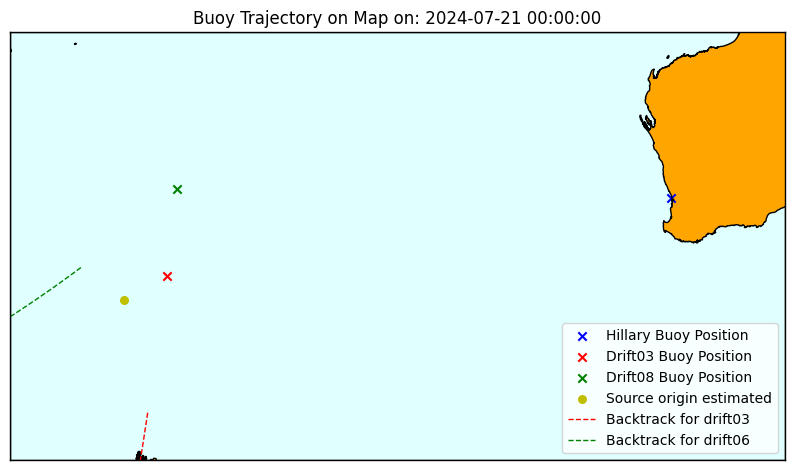

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-21 06:00:00--------
  Estimated time of source
   2024-07-16 14:19:53.643771
  Arrival time and uncertainty
   2024-07-20 10:19:53.643771
    --> Estimated spectral quantities:
     Estimated energy 0.0 vs real 4.309212776167406
     Estimated frequency 0.092775 vs real 0.06836
     Estimated direction 194.49852938092053 vs real 248.276


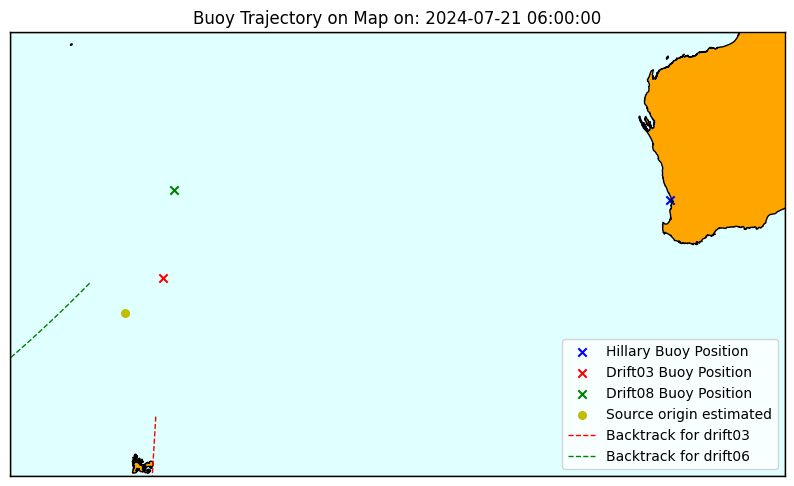

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-21 12:00:00--------
  Estimated time of source
   2024-07-16 03:46:16.379418
  Arrival time and uncertainty
   2024-07-19 19:46:16.379418
    --> Estimated spectral quantities:
     Estimated energy 0.0 vs real 5.0259928161071965
     Estimated frequency 0.10253999999999999 vs real 0.08789
     Estimated direction 189.79210154099133 vs real 257.788


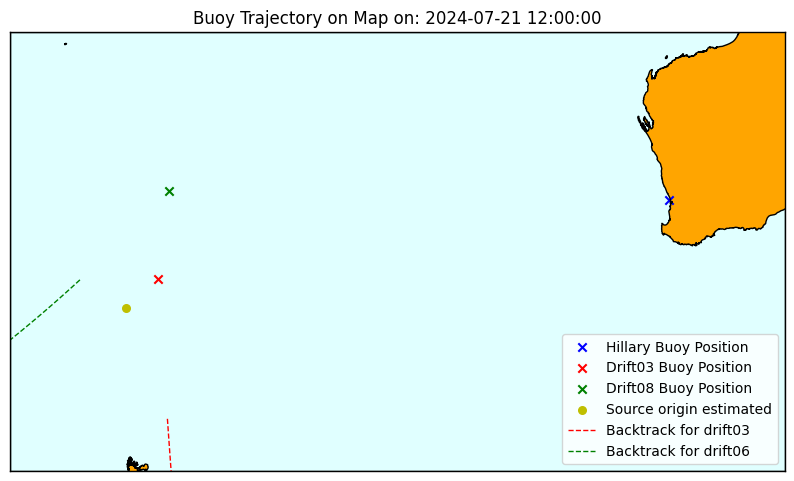

/tmp/ipykernel_2451923/2604454647.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2451923/2604454647.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




-------Time event on drifts: 2024-07-21 18:00:00--------
  Estimated time of source
   2024-07-16 03:46:16.379418
  Arrival time and uncertainty
   2024-07-19 01:46:16.379418
    --> Estimated spectral quantities:
     Estimated energy 0.0 vs real 5.0259928161071965
     Estimated frequency 0.10253999999999999 vs real 0.08789
     Estimated direction 181.23569034247137 vs real 257.788


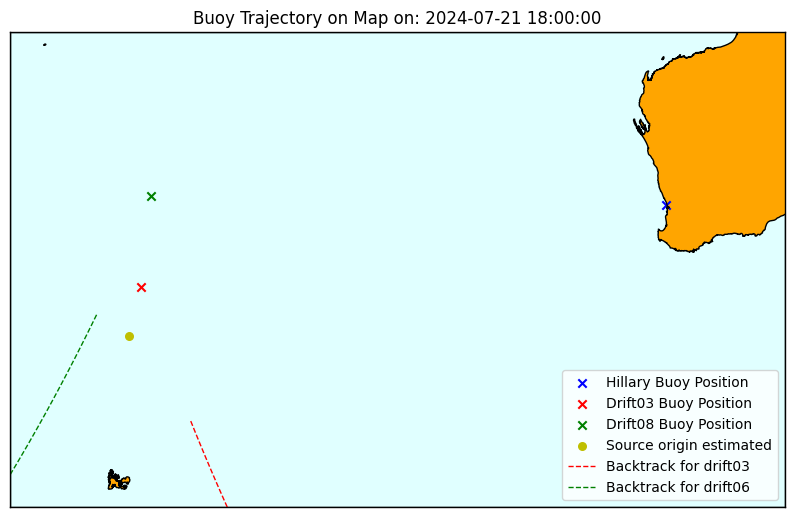

In [41]:
plot = False
for i in range(0, 240, 6):
    time_select_datetime = datetime(2024, 7, 12, 0) + timedelta(hours=i)
    fractional_day = (time_select_datetime.hour * 3600 + time_select_datetime.minute * 60 + time_select_datetime.second) / 86400.0
    time_select_ordinal = datetime.toordinal(time_select_datetime + timedelta(days = 366)) + fractional_day
    index_hillary = np.argmin(np.abs(spec_time_hillarys - time_select_ordinal))
    index_hillary_dp = np.argmin(np.abs(time_hillarys - time_select_ordinal))
    index_drift03 = np.argmin(np.abs(spec_time_drift03 - time_select_ordinal))
    index_drift03_dp = np.argmin(np.abs(time_drift03 - time_select_ordinal))
    index_drift06 = np.argmin(np.abs(spec_time_drift06 - time_select_ordinal))
    index_drift06_dp = np.argmin(np.abs(time_drift06 - time_select_ordinal))
    #time_select_datetime = datetime.fromordinal(int(time_select)) + timedelta(days=int(time_select%1)) - timedelta(days = 366)
    #time_select_datetime = time_select_datetime - timedelta(days=8)

    if plot:
        fig, ax = buoy_utils.plot_directional_spectrum(frequencies_drift03, directions_drift03, data_drifting03[index_drift03],
                                                title='Drift 03 Buoy - Directional Spectrum of time '+ str(time_select_datetime))
        fig, ax = buoy_utils.plot_directional_spectrum(frequencies_drift06, directions_drift06, data_drifting06[index_drift06],
                                                title='Drift 06 Buoy - Directional Spectrum of time '+ str(time_select_datetime))
        plt.show()

    hsig_h = np.concatenate([np.array(f_hillary.get('SpotData/hsig')), np.array(f_hillary_2.get('SpotData/hsig'))], axis=1)
    dp_h = np.concatenate([np.array(f_hillary.get('SpotData/dp')), np.array(f_hillary_2.get('SpotData/dp'))], axis=1)
    peak_freq_h = frequencies_hillarys[np.argmax(np.sum(data[index_hillary], axis=1))]
    peak_energy_h = np.max(data[index_hillary])
    spread_h_ = np.concatenate([np.array(f_hillary.get('SpotData/directionalSpread')), np.array(f_hillary_2.get('SpotData/directionalSpread'))], axis=1)
    spread_h = spread_h_[np.argmax(np.sum(data[index_hillary], axis=1)), index_hillary_dp]

    hsig_d03 = np.concatenate([np.array(f_drift03.get('SpotData/hsig')), np.array(f_drift03_2.get('SpotData/hsig'))], axis=1)
    dp_d03 = np.concatenate([np.array(f_drift03.get('SpotData/dp')), np.array(f_drift03_2.get('SpotData/dp'))], axis=1)
    peak_freq_d03 = frequencies_drift03[np.argmax(np.sum(data_drifting03[index_drift03], axis=1))]
    peak_energy_d03 = np.max(data_drifting03[index_drift03])
    spread_d03_ = np.concatenate([np.array(f_drift03.get('SpotData/directionalSpread')), np.array(f_drift03_2.get('SpotData/directionalSpread'))], axis=1)
    spread_d03 = spread_d03_[np.argmax(np.sum(data_drifting03[index_drift03], axis=1)), index_drift03_dp]

    hsig_d08 = np.concatenate([np.array(f_drift06.get('SpotData/hsig')), np.array(f_drift06_2.get('SpotData/hsig'))], axis=1)
    dp_d08 = np.concatenate([np.array(f_drift06.get('SpotData/dp')), np.array(f_drift06_2.get('SpotData/dp'))], axis=1)
    peak_freq_d08 = frequencies_drift06[np.argmax(np.sum(data_drifting06[index_drift06], axis=1))]
    peak_energy_d08 = np.max(data_drifting06[index_drift06])
    spread_d06_ = np.concatenate([np.array(f_drift06.get('SpotData/directionalSpread')), np.array(f_drift06_2.get('SpotData/directionalSpread'))], axis=1)
    spread_d06 = spread_d06_[np.argmax(np.sum(data_drifting06[index_drift06], axis=1)), index_drift06_dp]

    time_d03 = datetime.fromordinal(int(spec_time_drift03[:, index_drift03])) + timedelta(days=int(spec_time_drift03[:, index_drift03]%1)) - timedelta(days = 366)
    time_d08 = datetime.fromordinal(int(spec_time_drift06[:, index_drift06])) + timedelta(days=int(spec_time_drift06[:, index_drift06]%1)) - timedelta(days = 366)

    obs_d03 = buoy_utils.BuoyObservation(lat_d03[index_drift03], lon_d03[index_drift03], time_d03, data_drifting03[index_drift03], peak_freq_d03, dp_d03[:,index_drift03_dp], peak_energy_d03, spread_d03)
    obs_d08 = buoy_utils.BuoyObservation(lat_d06[index_drift03], lon_d06[index_drift03], time_d08, data_drifting06[index_drift06], peak_freq_d08, dp_d08[:,index_drift06_dp], peak_energy_d08, spread_d06)

    triangulation = buoy_utils.SwellBackTriangulation(obs_d03, obs_d08, [lat_h[0], lon_h[0]])
    source = triangulation.triangulate_source_location(method='intersection')

    arrival = triangulation.predict_coastal_arrival(source)

    time_arrival_ordinal = datetime.toordinal(arrival['arrival_time'] + timedelta(days = 366))
    index_hillary_arrival = np.argmin(np.abs(spec_time_hillarys - time_arrival_ordinal))
    index_hillary_dp_arrival = np.argmin(np.abs(time_hillarys - time_arrival_ordinal))
    peak_freq_h_arrival = frequencies_hillarys[np.argmax(np.sum(data[index_hillary_arrival], axis=1))]
    peak_energy_h_arrival = np.max(data[index_hillary_arrival])
    if plot:
        fig, ax = buoy_utils.plot_directional_spectrum(frequencies_hillarys, directions_hillarys, data_[index_hillary_arrival],
                                                title='Hillary Buoy - Directional Spectrum of estimated arrival time '+ str(arrival['arrival_time']))

    print("\n-------Time event on drifts: " + str(time_select_datetime) + "--------")
    print("  Estimated time of source")
    print("   " + str(arrival['source_generation_time']))
    print("  Arrival time and uncertainty")
    print("   " + str(arrival['arrival_time']))
    print("    --> Estimated spectral quantities:")
    print('     Estimated energy ' + str(arrival['arrival_energy'].item()) + ' vs real ' + str(peak_energy_h_arrival))
    print('     Estimated frequency ' + str(arrival['arrival_frequency'].values) + ' vs real ' + str(peak_freq_h_arrival.values))
    print('     Estimated direction '+ str(arrival['arrival_direction'].item()) + ' vs real ' + str(dp_h[:, index_hillary_dp_arrival].item()))

    b_lat_1 = np.array([c['lat'] for c in source['buoy1_backtrack']['all_candidates']]).squeeze()
    b_lon_1 = np.array([c['lon'] for c in source['buoy1_backtrack']['all_candidates']]).squeeze()

    b_lat_2 = np.array([c['lat'] for c in source['buoy2_backtrack']['all_candidates']]).squeeze()
    b_lon_2 = np.array([c['lon'] for c in source['buoy2_backtrack']['all_candidates']]).squeeze()

    min_lat = np.min(np.concatenate([lat_h, lat_d03, lat_d06, source['source_lat']]))#, b_lat_1, b_lat_2]))
    max_lat = np.max(np.concatenate([lat_h, lat_d03, lat_d06, source['source_lat']]))#, b_lat_1, b_lat_2]))
    min_lon = np.min(np.concatenate([lon_h, lon_d03, lon_d06, source['source_lon']]))#, b_lon_1, b_lon_2]))
    max_lon = np.max(np.concatenate([lon_h, lon_d03, lon_d06, source['source_lon']]))#, b_lon_1, b_lon_2]))

    plt.figure(figsize=(10, 8))
    m = Basemap(projection='merc',
                llcrnrlat=min_lat-10.0, urcrnrlat=max_lat+10.0,
                llcrnrlon=min_lon-10.0, urcrnrlon=max_lon+10.0,
                resolution='i')

    m.drawcoastlines()
    m.drawcountries()
    m.fillcontinents(color='orange', lake_color='aqua')
    m.drawmapboundary(fill_color='lightcyan')

    x, y = m(lon_h[0], lat_h[0])
    m.scatter(x, y, marker='x', color='b', label='Hillary Buoy Position')
    x, y = m(lon_d03[index_drift03], lat_d03[index_drift03])
    m.scatter(x, y, marker='x', color='r', label='Drift03 Buoy Position')
    x, y = m(lon_d06[index_drift06], lat_d06[index_drift06])
    m.scatter(x, y, marker='x', color='g', label='Drift08 Buoy Position')
    x, y = m(source['source_lon'], source['source_lat'])
    m.scatter(x, y, color='y', label='Source origin estimated', s=30)
    x, y = m(b_lon_1, b_lat_1)
    m.plot(x, y, linewidth=1.0, linestyle='--' ,color='r', label='Backtrack for drift03')
    x, y = m(b_lon_2, b_lat_2)
    m.plot(x, y, linewidth=1.0, linestyle='--', color='g', label='Backtrack for drift06')
    plt.title('Buoy Trajectory on Map on: '+ str(time_select_datetime))
    plt.legend(loc='lower right')
    plt.savefig('/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/plots/prediction_source/map_'+str(time_select_datetime)+'.png')
    plt.show()


## Estimate a co-occurrence frequency matrix for cluster identification

Implementation of co-occurrence frequency matrix to estimate the probability of happening cluster i at drift then observe cluster j after a lag l.

Distance from offshore to coastal buoy: 3883.2 km

=== Physics-Based Co-occurrence ===
[[0.65505079 0.29133747 0.02863995 0.02497178]
 [0.6589618  0.13418217 0.18432909 0.02252693]
 [0.78668901 0.08594685 0.03160163 0.09576251]]


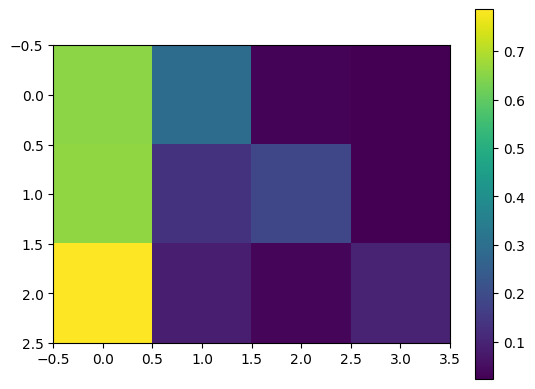

In [39]:
from hdpgpc import buoy_utils
clusters_df = ds_cluster_means_drift06['efth'].values
freq = ds_cluster_means_drift06['freq'].values
peak_dir_per_cluster = []
for i in range(np.unique(cluster_labels_d08).shape[0]):
    peak_dir_per_cluster.append(freq[np.argmax(np.sum(clusters_df[i], axis=1))])
peak_dir = np.array([peak_dir_per_cluster[j] for j in cluster_labels_d08])

# Now compute co-occurrence with physics
cooccurrence, prob_matrix, metadata = buoy_utils.compute_cooccurrence_matrix_with_physics(
    labels_offshore=cluster_labels_d08,
    labels_coastal=cluster_labels_h,
    timestamps_offshore=np.array(data_time_drift06),
    timestamps_coastal=np.array(data_time_hillarys),
    peak_frequencies_offshore=peak_dir,
    peak_directions_offshore=dp_d08[0],
    offshore_location=(np.mean(lat_d06), np.mean(lon_d06)),
    coastal_location=(lat_h[0], lon_h[0]),
    time_window_hours=6
)

print(f"\n=== Physics-Based Co-occurrence ===")
print(prob_matrix)
plt.imshow(prob_matrix)
plt.colorbar()

In [40]:
print(lon_h[0], lat_h[0])
print(lon_d03[0], lat_d03[0])
print(lon_d06[0], lat_d06[0])

# main_model = print_results(sw_gp_hillary, labels, 0, error=False)
# up.plot_models_plotly(sw_gp_hillary, [8], main_model, labels, N_0=0, lead=1, step=(freq[1]-freq[0])/1,
#                    plot_latent=False, title='WAVE CLUSTER',ticks=True, yscale=True)
# main_model = print_results(sw_gp_drift06, labels, 0, error=False)
# up.plot_models_plotly(sw_gp_drift06, [14], main_model, labels, N_0=0, lead=1, step=(freq[1] - freq[0]) / 1,
#                       plot_latent=False, title='WAVE CLUSTER', ticks=True, yscale=True)


print(sw_gp_hillary.gpmodels[0][16].x_train[0][np.argmax(sw_gp_hillary.gpmodels[0][16].f_star[-1])])
print(sw_gp_drift03.gpmodels[0][1].x_train[0][np.argmax(sw_gp_drift06.gpmodels[0][1].f_star[-1])])
print(sw_gp_drift06.gpmodels[0][2].x_train[0][np.argmax(sw_gp_drift06.gpmodels[0][2].f_star[-1])+1])

plt.figure()
plt.plot(sw_gp_hillary.gpmodels[0][16].x_train[0],sw_gp_hillary.gpmodels[0][16].f_star[-1], 'b')
plt.plot(sw_gp_drift03.gpmodels[0][1].x_train[0],sw_gp_drift03.gpmodels[0][1].f_star[-1], 'r')
plt.plot(sw_gp_drift06.gpmodels[0][2].x_train[0],sw_gp_drift06.gpmodels[0][2].f_star[-1], 'g')
plt.vlines(0.078, 0,70)
plt.show()


115.64628 -31.85168
70.51448 -37.05543
71.52583 -33.32688


IndexError: list index out of range

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from plotly.offline import plot
import plotly.io as pio
pio.renderers.default = 'notebook_connected'
pio.templates.default = 'plotly'

def plot_spectral_grid_mean(cluster_means, frequencies, directions):
    """
    Plots 3D spectral energy distributions using cluster mean tensors.

    Parameters:
        cluster_means (list of np.ndarray): List of K tensors representing cluster means.
        frequencies (np.ndarray): Frequency array corresponding to the clusters.
        directions (np.ndarray): Direction array corresponding to the clusters.
    """
    num_clusters = len(cluster_means)
    cols = min(2, num_clusters)
    rows = (num_clusters // cols) + (num_clusters % cols > 0)

    fig = make_subplots(
        rows=rows,
        cols=cols,
        subplot_titles=[f'Cluster {i__+1}' for i__ in range(num_clusters)],
        specs=[[{'type': 'surface'}] * cols for _ in range(rows)]
    )

    # Ensure directions include both 0° and 360°
    directions = np.append(directions, 360.0)  # Add 360° to the directions array
    directions_rad = np.radians(directions)  # Convert to radians

    # Extend cluster_means by repeating the values for 0° at 360°
    for i_ in range(len(cluster_means)):
        cluster_means[i_] = np.concatenate([cluster_means[i_], cluster_means[i_][:, [0]]], axis=1)

    # Generate meshgrid for plotting
    Freq, Theta = np.meshgrid(frequencies, directions_rad)
    X = Freq * np.cos(Theta)  # Use Freq as radial and Theta as angular
    Y = Freq * np.sin(Theta)

    # Loop through each cluster mean tensor and plot
    for idx, cluster_mean in enumerate(cluster_means):
        row, col = divmod(idx, cols)

        Z = cluster_mean.T  # Transpose for correct orientation

        surface = go.Surface(
            x=X,
            y=-Y,
            z=Z,
            colorscale='Spectral_r',
            opacity=1,
            showlegend=False,
            showscale=False
        )
        fig.add_trace(surface, row=row+1, col=col+1)

        # Add circles and directional labels
        max_frequency = np.max(frequencies)
        circle_radii = [0.75 * max_frequency, 0.5 * max_frequency, 0.25 * max_frequency]

        for freq in circle_radii:
            circle_x = freq * np.cos(np.linspace(0, 2 * np.pi, 100))
            circle_y = freq * np.sin(np.linspace(0, 2 * np.pi, 100))
            fig.add_trace(go.Scatter3d(
                x=circle_x,
                y=circle_y,
                z=np.zeros_like(circle_x),
                mode='lines',
                line=dict(color='black', width=0.5, dash='dash'),
                showlegend=False
            ), row=row+1, col=col+1)

        border_x = max_frequency * np.cos(np.linspace(0, 2 * np.pi, 100))
        border_y = max_frequency * np.sin(np.linspace(0, 2 * np.pi, 100))
        fig.add_trace(go.Scatter3d(
            x=border_x,
            y=border_y,
            z=np.zeros_like(border_x),
            mode='lines',
            line=dict(color='black', width=1),
            showlegend=False
        ), row=row+1, col=col+1)

        for angle in range(0, 360, 45):
            rad = np.radians(-angle)
            x = max_frequency * np.cos(rad)
            y = max_frequency * np.sin(rad)

            fig.add_trace(go.Scatter3d(
                x=[0, x],
                y=[0, y],
                z=[0, 0],
                mode='lines',
                line=dict(color='black', width=0.5, dash='dash'),
                showlegend=False
            ), row=row+1, col=col+1)
            fig.add_trace(go.Scatter3d(
                x=[x],
                y=[y],
                z=[0],
                mode='text',
                text=[f"{angle}°"],
                showlegend=False,
                textposition='bottom center'
            ), row=row+1, col=col+1)

    fig.update_layout(
        height=800 * rows,
        width=600 * cols,
        title_text='Cluster Mean Spectral Energy Distributions',
        showlegend=False,
    )

    for i in range(1, num_clusters + 1):
        fig.update_scenes(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=True),  # Ensure consistent z-axis scaling
            zaxis_range=[0, np.max(cluster_means)],  # Force consistent scale across plots
            bgcolor='rgba(0,0,0,0)',
            row=(i - 1) // cols + 1,
            col=(i - 1) % cols + 1
        )

    fig.show(renderer="svg")
    plot(fig, auto_open=False, filename='/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/plots/plot_means_directional_6.html')

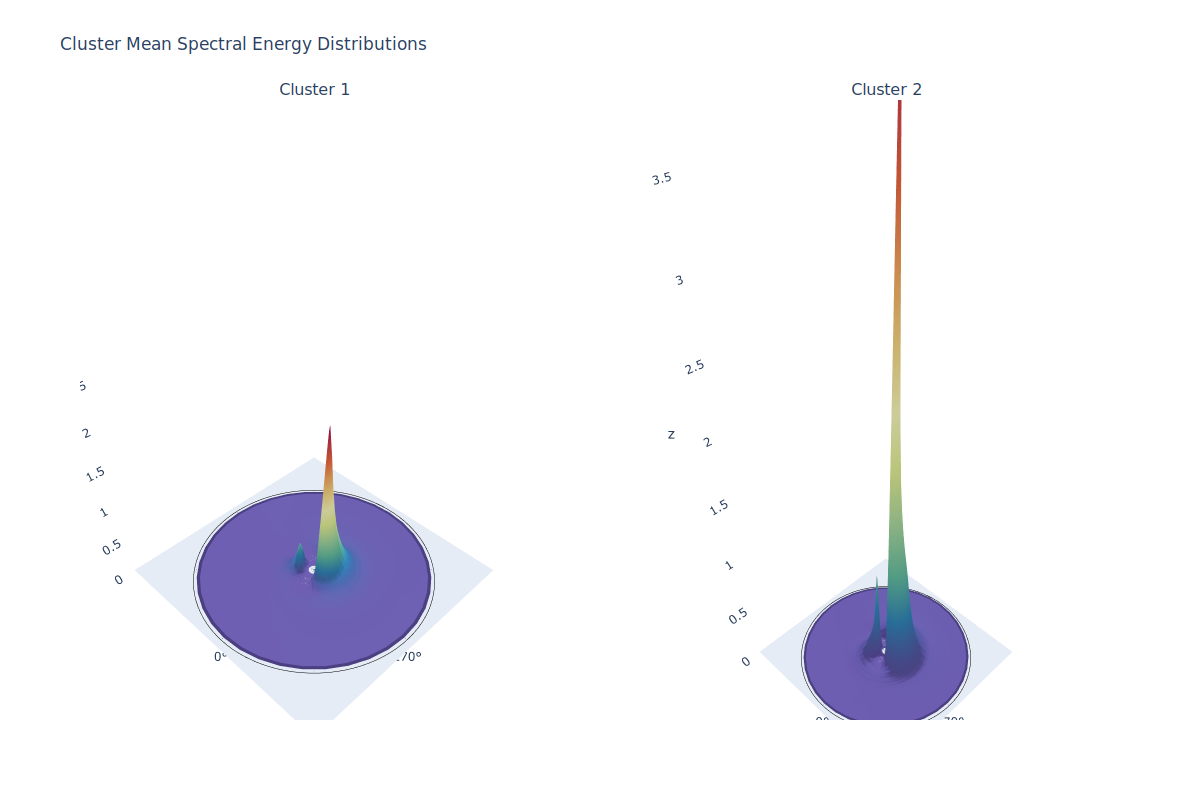

In [34]:
frequencies = freq_
directions_ = np.rad2deg(directions)
energy_spectral = data
tensors_list = []
for gp in sw_gp_hillary.gpmodels[0][:2]:
    subdata = np.mean(data[gp.indexes], axis=0)
    tensors_list.append(subdata)
plot_spectral_grid_mean(cluster_means=tensors_list, frequencies=frequencies, directions=directions_)

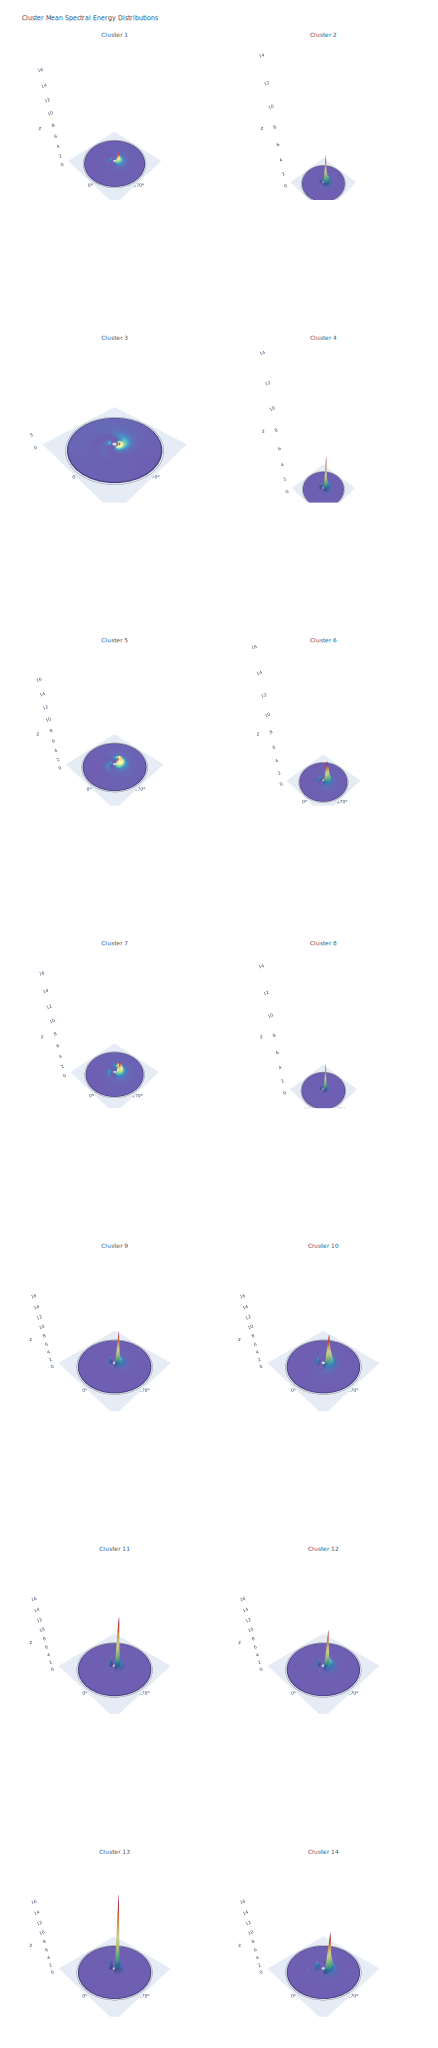

In [35]:
frequencies = freq_
directions_ = np.rad2deg(directions)
energy_spectral = data
tensors_list = []
for gp in sw_gp_hillary.gpmodels[0]:
    subdata = np.mean(data[gp.indexes], axis=0)
    tensors_list.append(subdata)
plot_spectral_grid_mean(cluster_means=tensors_list, frequencies=frequencies, directions=directions_)

---